## Preference-based Policy Iteration (PBPI) Algorithm 
### Application on the Inverted pendulum problem


- This work attempts to reproduce the PBPI algorithm proposed by Fürnkranz et al., (2012) in their paper "Preference-based reinforcement learning: a formal framework and a policy iteration algorithm"
- This algorithm is applied on the [inverted pendulum](https://en.wikipedia.org/wiki/Inverted_pendulum) problem. The source code of the environment can be found [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py)

---
##### Information about the task/environment.

**Description:**
>A pole is attached by an un-actuated joint to a cart, which moves along
a frictionless track. The pendulum starts upright, and the goal is to
prevent it from falling over by increasing and reducing the cart's
velocity.

**Observation:**
>Type: Box(4)

|Num|Observation|Min|Max|
|--|--|--|--|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-Inf|Inf|
|2|Pole Angle|-0.418 rad (-24 deg)|0.418 rad (24 deg)|
|3|Pole Angular Velocity|-Inf|Inf|

**Actions:**
>Type: Box(1)

|Action|Range|
|--|--|
|Push cart to the left|-1 <= x < 0 |
|No action| 0 |
|Push cart to the right| 0 < x <= 1 |

**Reward:**
- Reward is 1 for every step taken, including the termination step.


**Starting State:**
- All observations are assigned a uniform random value in [-0.05..0.05]

**Episode Termination:**
- Pole Angle is more than 12 degrees.
- Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
- Episode length is greater than 200.

**Solved Requirements:**
- Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.
---


**Questions/Concerns**:
- The algorithm might only work because the sampled starting states are close to each other.
- How the algorithm learns a policy for unseen states is not explained (only explanation is the trained neural network learning to derive good action selections due to it approximation capabilities).
- The exact policy definition authors followed is not given, i.e., how did they balance the exploration vs. exploitation.
- The given evaluation results (graphs) are made after running 750 experiments per task. It would have been nice to have confidence bounds of the SR (success rate) at each action count.
- The authors mention:
> [...]The policy iteration algorithms terminated if the learned policy was sufficient or if the *policy performance decreased* [...]
- Above sentence means the learned policies can be worsen by the learning algorithm. They also mention:
>[...] we plot a cumulative distribution of the success rates of all different parameter settings over a measure of learning complexity, where each point (x, y) indicates the *minimum complexity x* needed to reach a success rate of y.[...]
- This statement means that the same success rate could be achieved at higher complexity, but they've decided to show the minimum complexity on the chart. As per my observations, the result outcomes are very diverse (same experiment setup gives different results in different runs), and therefore, how can we be confident of the performance of this algorithm?
    - Also, does "[...] cumulative distribution of the success rates [...]" means that the sum should add upto 1? (SR = *the percentage of learned sufficient policies*, it is hard to understand what the plotted *# success rate* means)
- The evaluation process is only run from the selected starting states; this means the learned policy does not generalize over the complete state space.
- The authors migth have retrained the same `LabelRanker` model with new training data (thus, I decided to create a separate version of the algorithm using that approach).


**Observations**
- Regarding the policy, I saw that by constantly picking the 1st ranked action yeild low rewards during the evaluation process; it make sense because the learned `LabelRanker` does not know which action to pick at unseen states. There must have been a exploration vs. exploitation balancing process.
- If the random policy doesn't identify a good amount of preference training data in the first iteration, the algorithm breaks since there isn't sufficient data for the model to train on.
- Single layer neural network works the best. But high number of neuros yeild better results (may be it avoids overfitting and helps to generalize for unseen states).


In [1]:
########################################
### importing the necessary packages ###

import gym
from gym import wrappers
import custom_cartpole  # custom cart-pole environment

import numpy as np
import pandas as pd

import random

from scipy.stats import rankdata as rd
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML

import io
import base64
import itertools
import tqdm
import os

########################################

In [147]:
########################################
########## custom environment ##########

# # maximum length of a trajectory set to 1500 steps
# gym.envs.register(id='CartPole_PbPI_Version-v0'
#                   , entry_point='gym.envs.classic_control:CartPoleEnv'
#                   , max_episode_steps=1500)


########## helper functions ##########

# generate a random action from a given environment
def random_action(environment, seed=10):
    """ return a random action from the given environment. """
    
    # set env. seeds for reproducibility
    #environment.action_space.np_random.seed(seed) 
    #environment.seed(seed) 
    
    return environment.action_space.sample()


# generate a list of initial states from a given environment
def generate_init_states_S(seed
                           , env = 'CustomCartPole-v0'):
    """ this function returns a list of randomly generated initial states from a given environment. """
    
    # set the random seed for reproducibility
    np.random.seed(seed)
    
    # define how many states to generate (total)
    n_states = np.random.randint(low=30, high=40) 
    
    # define how many states to generate (sample)
    n_states_sample = np.random.randint(low=20, high=22) 

    # define a list to store the generated initial states
    init_states_S = []

    # create a given environment object
    env = gym.make(env)
    env.action_space.np_random.seed(seed) # set env. seeds for reproducibility
    env.seed(seed) # set env. seeds for reproducibility
    env.reset(init_state = np.array([0,0,0,0]))

    s_count = 0
    # create initial states
    while s_count < n_states:

        # step through the environment
        state, reward, done, info = env.step(env.action_space.sample())  
            
        # if terminates, reset the environment
        # and continue to next step (without appending to state list)
        # increment 'n_states' count by 1
        # remove the last 1 state(s) from the appended list (avoid having states close to termination)
        if done: 
            env.reset(init_state = np.array([0,0,0,0]))
            n_states+=5
            init_states_S = init_states_S[:-5]
            continue
            
        # append the geneareted state to list
        init_states_S.append(state)
        
        s_count +=1
      
    env.close()
    
    # remove any duplicate state values from the list
    state_str_li = []
    for state in init_states_S:
        state_str_li.append("".join([str(item[0]) for item in [item.reshape(-1) for item in state.flatten()]]))

    uniq, uni_id = np.unique(state_str_li, return_index=True)

    init_states_S = [init_states_S[j] for j in uni_id]
    
    # sample selected number of states
    sampled_states = random.sample(init_states_S, n_states_sample)
            
    return sampled_states
    #return init_states_S
    

# partition the action space of a given environment 
def partition_action_space(env_name:'string'
                           , n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)

    # partition the action space to a given number of actions
    part_act_space = np.linspace(env.action_space.low[0,0]
                                 ,env.action_space.high[0,0],n_actions)
    
    return part_act_space  


########################################

In [144]:
########################################
########### EXTRA : EXAMPLES ###########

# generate a list of sample states and plot 20 states
init_states_S = generate_init_states_S(16)

env = gym.make('CustomCartPole-v0')
fig = plt.figure(figsize=(20,10))

for i in range(20):
    env.reset(init_state = init_states_S[i]) # set state
    fig.add_subplot(4,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

# example of partitioning the action space
#print("Original action space: " + str(env.action_space.n))
print("Partitioned into 3 actions: " + str(partition_action_space('CustomCartPole-v0',3)))

########################################

/nfs/_other_projects/PbRL/environments/custom_cartpole/custom_cartpole/envs/custom_cartpole_env.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.state), reward, done, {}


NameError: name 'sampled_states' is not defined

### Preference-based (approximate) policy iteration algorithm

This algorithm includes two main functions and a class:
 - `evaluate_preference` (func) : this function generates roll-outs to create preferences between pairs of actions at each initial states.
 - `train_model` (func) : this function uses the generated preference data to estimate the `LabelRanker` model.
 - `Policy` (class) : this class takes the trained `LabelRanker` model and generate a policy for the agent to follow.

In [145]:
#####################################
### preference generation process ###

def evaluate_preference(starting_state # starting state of roll-outs
                        , action_1     # first action to execute at the starting-state
                        , action_2     # second action to execute at the starting state
                        , policy_in    # policy to folow
                        , environment_name = 'CustomCartPole-v0'   # name of the environment
                        , discount_fac = 1        # discounting factor
                        , n_rollouts = 20         # number of roll-outs to generate per action
                        , max_rollout_len = 1500  # maximum length of a roll-out
                        , label_ranker = False    # whether to use the label-ranking model or not
                        , p_sig = 0.05            # p-value to use for t-test (to compare returns of roll-outs)
                        , tracking = False
                        ):
    
    """
    Description:
    
        - Roll-outs are generated at each state in the initial state set by starting from the given input action 
          and following the given policy afterwards. 
        - Returns of the roll-outs are used to generate preferences for the input action pair.
        - Generated preferences are returned to be create a training dataset to learn the LabelRanker model.    
    """
    
    # initializing variables
    policy = policy_in          
    n_rollouts = n_rollouts     
    gamma = discount_fac    
    s_init = starting_state
    max_traj_len = max_rollout_len 
        
    # we store the num. actions executed within the evaluation process (to measure complexity)
    action_count = 0 
        
    # dictionary to store input action values
    actions = { 'one' : action_1    
              , 'two' : action_2}    

    # dictionary to store rewards of roll-outs
    r = { 'one' : [None]*n_rollouts 
        , 'two' : [None]*n_rollouts}  

    # dictionary to store average discounted return for each action
    avg_r = {}  
    
    # select each action of the input actions to generate roll-outs:
    for action_key, action_value in actions.items():

        # generate the defined number of roll-outs for selected action
        for rollout in range(n_rollouts):

            # create an environment object and set the starting state to the input (initial) state
            env = gym.make(environment_name)
            env.reset(init_state=s_init) # modified env.reset() in custom env: it accepts a starting state

            # genereate random noice for action
            rand_act_noice =  np.array([[np.random.uniform(low = -.2,high=.2)]])
                                            
            # apply the action (custom environment accepts float actions)
            observation, reward, done, info = env.step(np.clip(action_value + rand_act_noice,-1,1)) # clip action value to (-1,1) range
            
            # define the history variable to store the last observed state
            hist = observation 
            
            # add the immediate reward received after executing the action
            r[action_key][rollout] = reward  

            # follow the given policy to generate a roll-out trajectory 
            traj_len = 1
            while traj_len < max_traj_len and not done: 
                
                # sample next state using the label-ranking model (if TRUE)
                if label_ranker: 
                    observation, reward, done, info = env.step(policy.label_ranking_policy(hist))
                    
                    # replace current history with the observed state
                    hist = observation
                    action_count+=1
                
                # sample next state using a random policy
                else: 
                    observation, reward, done, info = env.step(policy(env))
                    action_count+=1

                # compute discounted-reward at each step of the roll-out and store the roll-out return
                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            # close the environment after creating roll-outs
            env.close()
            del env
        
        # calculate the average discounted returns of the two actions
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])

    # run a t-test to check whether the observed difference between average returns is significant
    # (unpaird t-tests: equal variance)
    t_val, p_val = stats.ttest_ind(r['one'],r['two']) 
    
    # track output
    if tracking:
        print(f"state: {[state_dim.reshape(-1)[0] for state_dim in [s_init[2],s_init[3][0][0]]]} | a_j(R): {avg_r['one']} | a_k(R): {avg_r['two']} | sig: {'Yes' if (p_val <= p_sig) else '--'}")
    
    # return preference information
    if (avg_r['one'] > avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}, action_count
    
    elif(avg_r['one'] < avg_r['two']) and (p_val <= p_sig):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}, action_count
    
    # return NaN if avg. returns are not significantly different from each other OR are equal
    else: 
        return {'state': np.nan
               , 'a_j' : np.nan
               , 'a_k' : np.nan
               , 'preference_label' : np.nan}, action_count
    
#####################################

In [146]:
init_states_S = generate_init_states_S(2)
evaluate_preference(starting_state=init_states_S[0]
                    , action_1 = np.array([[0]])
                    , action_2 = np.array([[1]])
                    , policy_in = random_action
                   , tracking=True)

NameError: name 'sampled_states' is not defined

In [151]:
##########################################
### LabelRanker Model training process ###

def train_model(train_data                  # collection of all preference data
                , action_space              # action space of the task
                , model_name:str            # name for the model (to store)
                , batch_s = 4               # batch size to train the NN model
                , mod_layers = [100]       # model configuration
                , n_epochs = 300            # num. of epochs to train the model
                , l_rate = 0.01             # learning rate for the optimization process  
                , show_train_plot = False): # flag to display the 'training-loss vs. epoch' plot    
    
    
    """
    Description:
    
        - This function process all preference data to construct a training dataset for the LabelRanker model.
        - One training sample takes the form:
            X: [state-value (2-D)]
            Y: [(normalized) ranking of actions (n-D)], where 'n' is the number of actions in the action space.
        - For a given (2-D) state input, the (trained) model, i.e., LabelRanker, predicts the rank of 
           all possible actions at the input state 
    """

    
    ### creating the training dataset ###
        
    # convert training data input to a dataframe | 
    # remove the rows that have NaN, i.e.,preference evaluations without any action preference
    train_df = pd.DataFrame(train_data).dropna()

    # create a key for each state in the dataset
    # (only select the 'pendulum-velocity & pendulum-angle)
    #train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[2].astype(str)+"_"+x[3].astype(str))
    #train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: round(x[2].reshape(-1)[0],6).astype(str)+"_"+round(x[3].reshape(-1)[0],6).astype(str))
    train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[2].reshape(-1)[0].astype(str)+"_"+x[3].reshape(-1)[0].astype(str))

    
    # ******************************** # EXPERIMENTAL STEP START
    # create a full state key (state+action preference)
    #train_df.loc[:, 'state_action_key'] = train_df.state.apply(lambda x: round(x[2],6).astype(str)+"_"+round(x[3],6).astype(str)) +"_"+ train_df.a_j.apply(lambda x: x[0][0].astype(str))+"_"+ train_df.a_k.apply(lambda x: x[0][0].astype(str)) 

    
    # drop duplicates (if one training-set maintained) : only keep the first learned preference
    #train_df.drop_duplicates(subset=['state_key'], keep='first', inplace=True)
    #train_df.drop_duplicates(subset=['state_action_key'], keep='first', inplace=True)
    
    #train_df.drop(columns=['state_action_key'], inplace=True)
    
    # ******************************** # EXPERIMENTAL STEP END
    
    # check if the training dataset is empty 
    # (if empty, subsequent steps have to be skipped)
    if not(train_df.shape[0]>0):
        
        # if training dataset is emtpy - return None (break the training loop)
        return None
    
    else:
        
        ### computing action-preference counts for every action (for every states) ###
        
        # identify the 'prefered-action' at each 'state, action-pair' preference evaluation
        train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'][0][0] if row['preference_label'] == 1 else row['a_k'][0][0]  ,axis=1)

        # compute the number of times each action is prefered at each state
        action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
        action_preference_counts.replace(np.nan,0,inplace=True) # if an action is not preferred at a state, set pref. count to '0'

        # remove the column index names of the `action_preference_counts' summary table
        action_preference_counts.columns.name = None

        # find any action(s) that was not preferred at all sampled states 
        # - this is important because a ranking for every possible action
        #   at each state needs to be included in the training (label) data
        missed_actions = [action for action in action_space if action not in action_preference_counts.columns.tolist()]
        missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # convert to the same data-type of remaining columns

        # add any missing actions to the `action_preference_counts' table
        if len(missed_actions)>0:

            # add the missing action (with a preference count of zero)
            for action in missed_actions:
                action_preference_counts.loc[:,action] = 0

            # sort the actions in the summary according to arrangement in action space (ascending order)
            action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)    

        
        # convert the action-preference-counts (of actions at each state) to a vector and add it as a new column
        #  - data in this column is used to create training labels
        action_preference_counts.loc[:, 'preference_label_vector'] = pd.DataFrame({'label_data': action_preference_counts.iloc[:,0:].values.tolist()}).values

        # append the column having action-preference-counts vectors to the training dataset
        train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                                  , right_index= True
                                  , left_on = 'state_key'
                                  , how = 'left')
        

        # create the reduced training dataset 
        # - drop unnecessary columns & duplicate rows (which have duplicate data for same states)
        train_df_reduced = train_df.loc[:,['state', 'state_key', 'preference_label_vector']]
        train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)
        train_df_reduced.preference_label_vector = train_df_reduced.preference_label_vector.apply(lambda row: np.array(row).astype(np.float)) # convert all label vectors to float
        
        print(f'Training data samples: {train_df_reduced.shape[0]}')
    
        print(train_df_reduced.loc[:,['state_key', 'preference_label_vector']])
        
        ### preparing the training dataset for the neural network (LabelRanker) model ###

        # normalize the action-preference-counts vectors (label data for the model)
        # - this step produces the rankings:
        # - i.e., the action(s) with the highest preference count(s) will have the highest value(s)
        # - after normalization
        output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
        row_sums = output_labels_temp.sum(axis=1)
        output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]
        output_labels = torch.from_numpy(output_labels_normalized) # convert to tensor

        # generate the input state data tensors (feature data for the model)
        # - this should only include pendulum-angle and pendulum-velocity
        #input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [x[2].astype(float),x[3].astype(float)]).tolist())) # only select pole-position and pole-velocity
        #input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [round(x[2].reshape(-1)[0],6).astype(float),round(x[3].reshape(-1)[0],6).astype(float)]).tolist())) # only select pole-position and pole-velocity
        input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: [x[2].reshape(-1)[0].astype(float),x[3].reshape(-1)[0].astype(float)]).tolist())) # only select pole-position and pole-velocity

        
        # create TensorDataset
        train_ds = TensorDataset(input_states , output_labels)
        
        # define the batch size
        batch_size = batch_s #train_df_reduced.shape[1]
        
        # define the data loader
        train_dl = DataLoader(train_ds
                              , batch_size
                              , shuffle=True
                              #, drop_last=True
                             )
        
        
    ### defining and training the neural network (LabelRanker) model ###        
    
    class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.3):

            super(Model,self).__init__()

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.LeakyReLU(inplace=True))
                #all_layers.append(nn.BatchNorm1d(layer_dim))
                #all_layers.append(nn.Dropout(p))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.layers(state_vec)
            return x

        
    # create a NN model instance
    model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

    # define optimizer and loss
    opt = torch.optim.SGD(model.parameters(), lr = l_rate)
    loss_fn = F.mse_loss

    # list to store losses
    aggregated_losses = []

    # defining a function to train the model
    def fit(num_epochs, model, loss_fn, opt):
        
        for epoch in range(num_epochs):
            for xb,yb in train_dl:

                # Generate predictions
                pred = model(xb.float())
                loss = loss_fn(pred, yb.float())

                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()

            aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())

        print('\nTraining loss: ', loss_fn(model(input_states.float()), output_labels.float()).detach().numpy(),'\n')

        
#     print('Training model...\n',end='\r')

    # train the model
    epochs = n_epochs
    fit(epochs, model, loss_fn, opt)

    # save the trained model
    PATH = f"./models/{model_name}_pbpi_model.pt"
    torch.save(model.state_dict(), PATH)
    
    # plot the model loss
    if show_train_plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.show()

    # set the model to evaluation mode and return it
    return model.eval()

##########################################

In [152]:
########################################
### Derived policy using LabelRanker ###

class Policy():
    
    """
    Description:
    
        - This Policy object takes a given neural network (LabelRanker) model and uses it to define a policy for the agent to follow
    """
    
    def __init__(self, action_space, model):
        self.action_space = action_space # action space of the current environment
        self.model = model               # trained NN (LabelRanker) model
        
    def label_ranking_policy(self,obs):
        """ Produces an action for a given state based on the LabelRanker model prediction
            Note: only the pendulum-angle and pendulum-velocity of the input state are considered when producing an action
        
            At each input state:
                - Highest ranked action is selected with a prob. of 0.95
                - Second highest ranked action is selected with a prob. of 0.04
                - Any remaining actions are selected with an equal proabability of .01 """


        # only select the pendulum-velocity and angle from the input state vector
        #state_obs = np.array([obs[2].reshape(-1)[0],obs[3].reshape(-1)[0]]) 
        #state_obs = np.array([round(obs[2].reshape(-1)[0],6),round(obs[3].reshape(-1)[0],6)]) # rounded input
        state_obs = np.array([obs[2].reshape(-1)[0],obs[3].reshape(-1)[0]])
        
        #state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
        state_obs = torch.from_numpy(state_obs) # convert to a tensor

        # make ranking predictions for all actions
        with torch.no_grad():
            preds = self.model(state_obs.float()) 

        # rank the indexes of actions (from highest ranked/preferred action to lowest)
        #ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]
        ranked_action_idx = (-rd(preds.detach().numpy())).argsort()

        
        ### return the selected action ###
        
        # if there are more than 2 actions
        if len(self.action_space)>2:
            
            # compute the probabilities for the 3rd action onward
            remain_probs = .00/len(ranked_action_idx[2:])
            n_remain_actions = ranked_action_idx.shape[0]-2

            # since we add random noise to action, policy becomes stochastic (even if we select the 1st ranked action always)
            # select one of the remaining actions 1% time
            action = np.random.choice(ranked_action_idx,1 , p=[1.0, 0.00] + list(np.repeat(remain_probs,n_remain_actions)))[0]
        
        else:
            
            # if there are only 2 actions: select highest preferred actions 95% and 5% of the time
            action = np.random.choice(ranked_action_idx,1 , p=[1.0, 0.00])[0]
        
        # when action space is partitioned, return the corresponding action
        # - a uniform noise term is added to action signals to make all state transitions non-deterministic 
        # clip action value to (-1,1) range
        return np.array([[np.clip(self.action_space[int(action)] + np.array(np.random.uniform(low = -.2,high=.2),dtype=float),-1,1)]])
    

########################################

In [153]:
######################################
### Evaluating the learned policy ####


def run_evaluations(policy               # input policy
                    , state_list         # list of initial states
                    , step_thresh = 100    # step-count (threshold)
                    , env_name = 'CustomCartPole-v0' # name of the environment
                    , simulations_per_state = 100 # number of simulations to generate per state
                   ):  
    
    """
    Description:
    
        - For every state in a given list of initial states, 100 simulations are generate and the percentage of
           these simulations that exceeds a predefined step-count threadhold (trajectory length) is computed to measure 
           the performance of the given input policy."""
    

    simu_per_state = simulations_per_state
        
    # create an environment instance
    env_test = gym.make(env_name)
    
    # variable to record the sufficient policy count (across all simulations)
    suf_policy_count = 0
    
    # variable to record episodic returns
    ep_returns = []
    
    # iterate over all states in the state list
    for state in state_list:        
        
        # generate 100 simulations from each state
        for _ in range(simu_per_state):
            
            # set the starting state and the current observation to the given state 
            env_test.reset(init_state=state)
            obs = state
        
            # variable to store the return of an episode
            return_ep = 0 

            # execute 1001 steps in the environment
            for _ in range(1001):
                action = policy.label_ranking_policy(obs) # generate action from the policy
                observation, reward, done, info = env_test.step(action) # execute action
                obs = observation     # set history
                return_ep += reward   # compute return
                if done: break

            env_test.close()

            # append the return of the episode
            ep_returns.append(return_ep)
            
            # increment the sufficient policy count if return exceeds given threshold
            # (note: at every step, 1 reward is produced in the environment)
            if return_ep>=step_thresh:
                suf_policy_count += 1
    
    # return the 'aggregated sufficient policy counts' from the policy evaluation & the 'avg. episodic return'
    return (suf_policy_count/(len(state_list)*simu_per_state)), (sum(ep_returns)/(len(state_list)*simu_per_state))

#######################################


Number of initial states: 21


Number of actions (per states): 3



/nfs/_other_projects/PbRL/environments/custom_cartpole/custom_cartpole/envs/custom_cartpole_env.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.state), reward, done, {}


Iteration 1:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.5 | a_k(R): 5.6 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.05 | a_k(R): 5.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 8.25 | a_k(R): 10.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 7.85 | a_k(R): 11.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 13.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.45 | a_k(R): 12.5 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 9.65 | a_k(R): 11.7 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 12.55 | a_k(R): 12.05 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 6.8 | a_k(R): 7.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 7.0 | a_k(R): 10.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.15 | a_k(R): 10.25 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 8.15 | a_k(R): 11.85 | sig: Yes
state: [0.

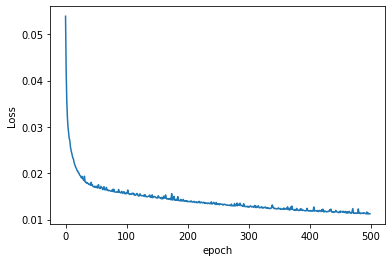

Evaluations...


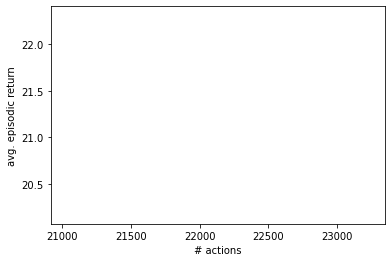

Iteration 2:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.9 | a_k(R): 23.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.85 | a_k(R): 29.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 25.15 | a_k(R): 28.15 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 19.3 | a_k(R): 26.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 19.4 | a_k(R): 28.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 27.4 | a_k(R): 29.8 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 13.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 16.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.65 | a_k(R): 15.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 15.6 | a_k(R): 21.3 | sig: Yes
state

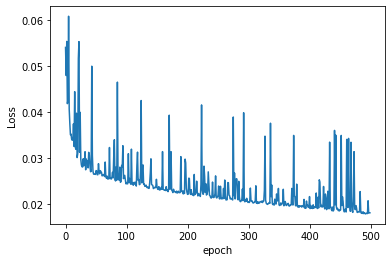

Evaluations...


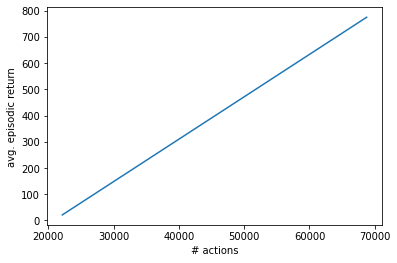

Iteration 3:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 1349.55 | a_k(R): 1100.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 1314.9 | a_k(R): 1047.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 1010.7 | a_k(R): 1071.4 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 1223.8 | a_k(R): 1120.55 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 1206.0 | a_k(R): 1058.7 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 1142.65 | a_k(R): 1104.95 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 1463.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 1272.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 1425.2 | a_k(R): 1207.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 1347.45

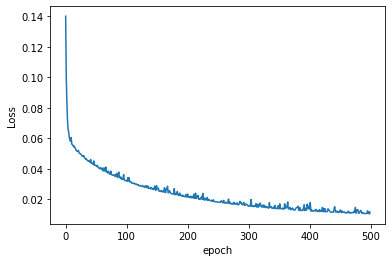

Evaluations...


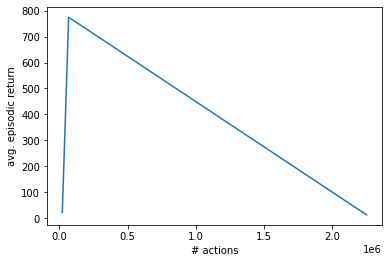

Iteration 4:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 12.5 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 12.75 | a_k(R): 14.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.75 | a_k(R): 13.3 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 12.85 | a_k(R): 14.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 13.0 | a_k(R): 17.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 14.35 | a_k(R): 17.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.1 | a_k(R): 11.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 14.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.1 | a_k(R): 15.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.8 | a_k(R): 12.8 | sig: --
state

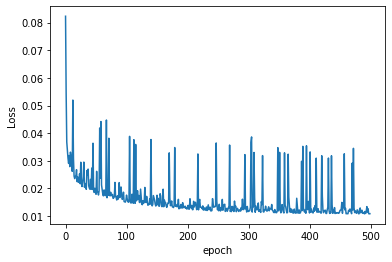

Evaluations...


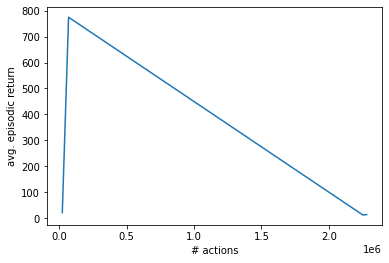

Iteration 5:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 23.6 | a_k(R): 16.75 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 23.4 | a_k(R): 14.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 16.85 | a_k(R): 14.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 18.05 | a_k(R): 15.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 17.95 | a_k(R): 14.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 15.55 | a_k(R): 14.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 23.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.8 | a_k(R): 17.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 24.6 | a_k(R): 17.9 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 22.7 | a_k(R): 16.55 | sig: Yes
stat

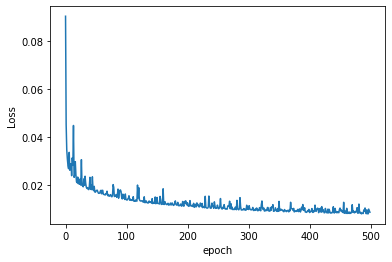

Evaluations...


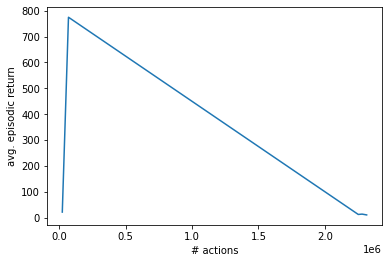

Iteration 6:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.8 | a_k(R): 10.95 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.95 | a_k(R): 12.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 12.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 12.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 13.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.85 | a_k(R): 13.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.75 | a_k(R): 10.7 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.7 | a_k(R): 11.3 | sig: Yes
state: 

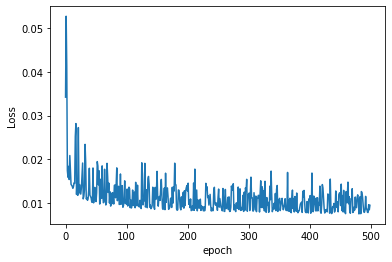

Evaluations...


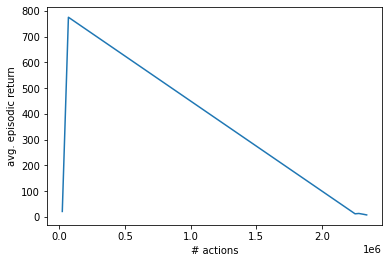

Iteration 7:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 5.05 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 9.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.35 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.8 | a_k(R): 13.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.9 | a_k(R): 9.6 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 13.2 | a_k(R): 9.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.45 | a_k(R): 9.25 | sig: Yes
state: [0.052084

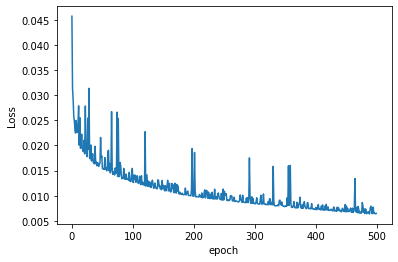

Evaluations...


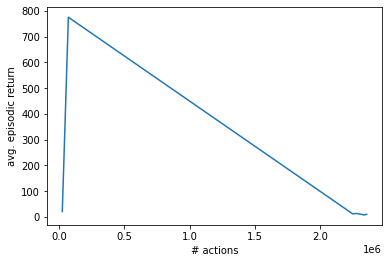

Iteration 8:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 10.85 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.7 | a_k(R): 12.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 12.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 11.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.05 | a_k(R): 13.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.8 | a_k(R): 13.8 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.75 | a_k(R): 10.05 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 10.2 | a_k(R): 10.75 | sig: Yes
state:

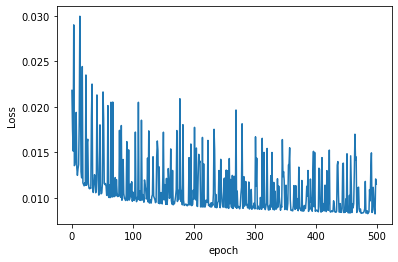

Evaluations...


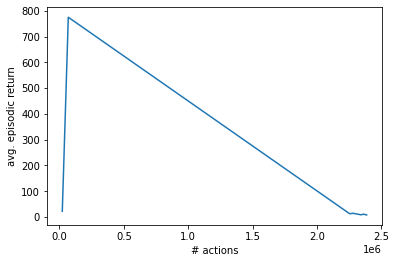

Iteration 9:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 5.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.15 | a_k(R): 9.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.0 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.7 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.15 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 7.4 | a_k(R): 12.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 7.45 | a_k(R): 9.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.55 | a_k(R): 9.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 14.5 | a_k(R): 9.15 | sig: Yes
state: [0.05208

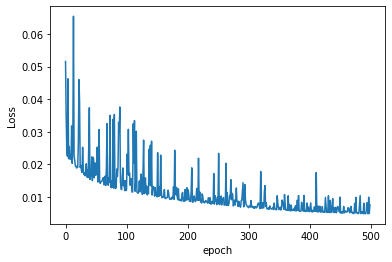

Evaluations...


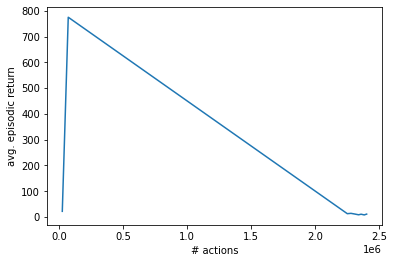

Iteration 10:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 11.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.7 | a_k(R): 12.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.5 | a_k(R): 12.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.4 | a_k(R): 12.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.4 | a_k(R): 14.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.25 | a_k(R): 14.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.3 | a_k(R): 9.8 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.3 | a_k(R): 10.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.85 | a_k(R): 10.7 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.55 | a_k(R): 11.25 | sig: Yes
state: [

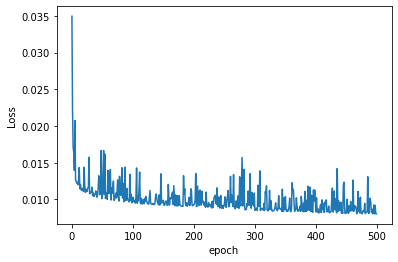

Evaluations...


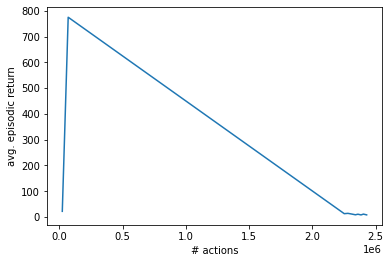

Iteration 11:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.7 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 9.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.45 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.1 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.25 | a_k(R): 11.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.15 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.05 | a_k(R): 9.55 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.45 | a_k(R): 9.15 | sig: Yes
state: [0.052

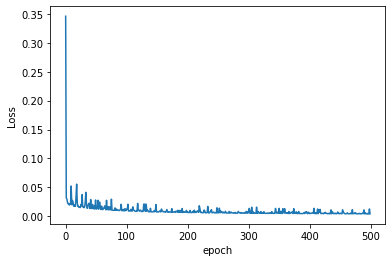

Evaluations...


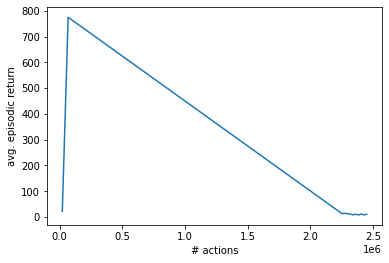

Iteration 12:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 11.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 12.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.25 | a_k(R): 12.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.15 | a_k(R): 12.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 14.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.05 | a_k(R): 14.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 9.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 10.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 10.7 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.8 | a_k(R): 11.0 | sig: --
state:

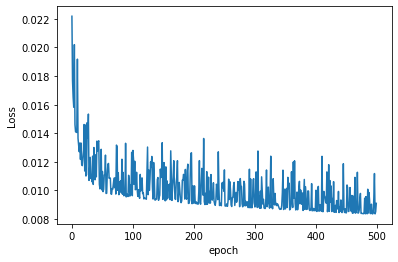

Evaluations...


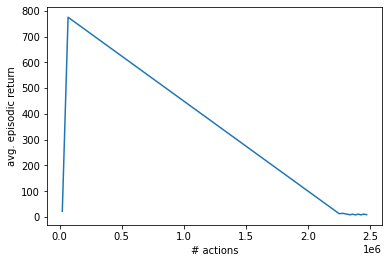

Iteration 13:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.4 | a_k(R): 10.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.85 | a_k(R): 8.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.35 | a_k(R): 8.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 9.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.95 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.05 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.45 | a_k(R): 14.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 10.35 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 14.25 | a_k(R): 10.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.45 | a_k(R): 10.2 | sig: Yes
state: [0

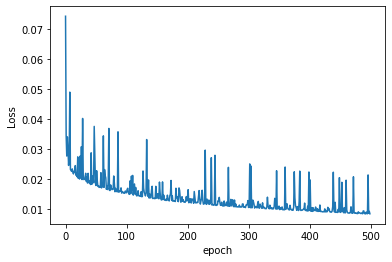

Evaluations...


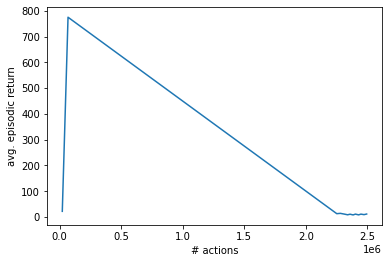

Iteration 14:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.2 | a_k(R): 11.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.35 | a_k(R): 12.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.7 | a_k(R): 13.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.75 | a_k(R): 12.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.6 | a_k(R): 14.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.65 | a_k(R): 14.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.55 | a_k(R): 10.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.55 | a_k(R): 11.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 11.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.35 | a_k(R): 11.55 | sig: --
state

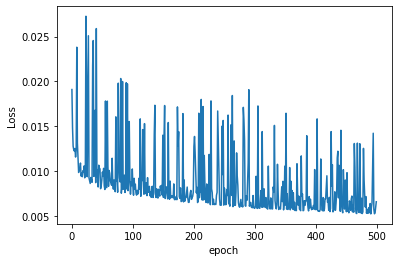

Evaluations...


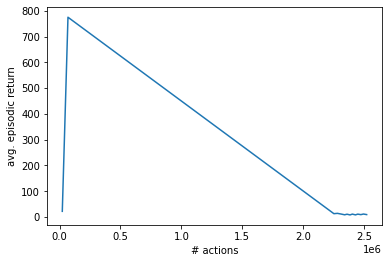

Iteration 15:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.1 | a_k(R): 10.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.65 | a_k(R): 9.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 9.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 9.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.3 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 14.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 10.3 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 14.5 | a_k(R): 10.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.25 | a_k(R): 10.15 | sig: Yes
state: [0.0

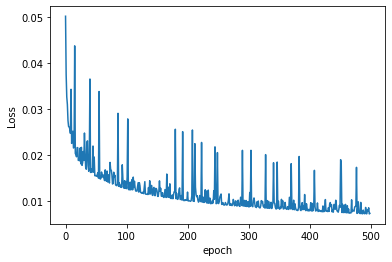

Evaluations...


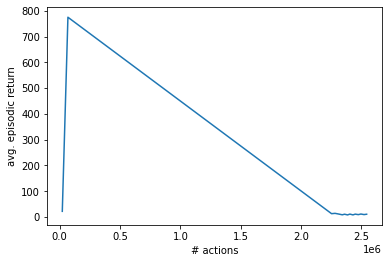

Iteration 16:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 10.85 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 12.15 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 11.95 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 11.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 13.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.95 | a_k(R): 13.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.85 | a_k(R): 10.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.5 | a_k(R): 10.15 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.6 | a_k(R): 10.95 | sig: --
state:

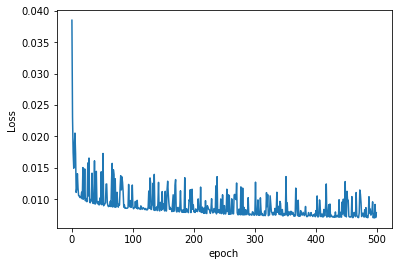

Evaluations...


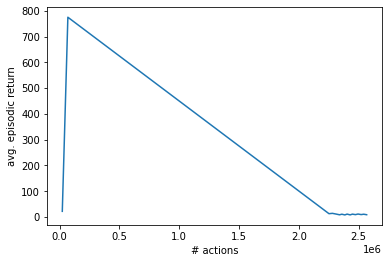

Iteration 17:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 9.75 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.3 | a_k(R): 8.15 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.8 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.4 | a_k(R): 8.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.5 | a_k(R): 7.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.55 | a_k(R): 7.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 13.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 9.95 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 14.15 | a_k(R): 10.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.65 | a_k(R): 9.65 | sig: Yes
state: [0.0

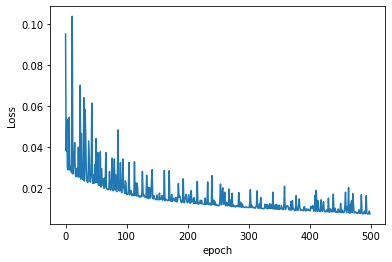

Evaluations...


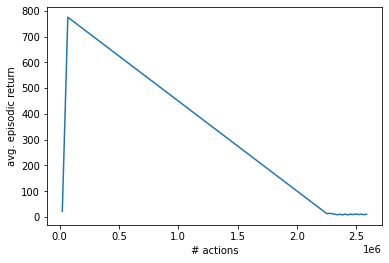

Iteration 18:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.45 | a_k(R): 11.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.4 | a_k(R): 12.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.5 | a_k(R): 13.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.55 | a_k(R): 12.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.4 | a_k(R): 14.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.2 | a_k(R): 14.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.5 | a_k(R): 9.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.75 | a_k(R): 10.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.1 | a_k(R): 11.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.45 | a_k(R): 11.4 | sig: Yes
state: 

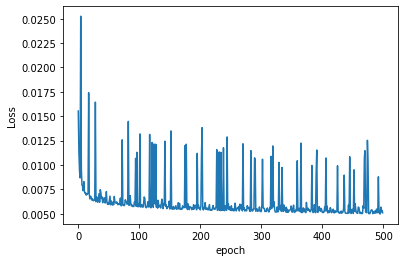

Evaluations...


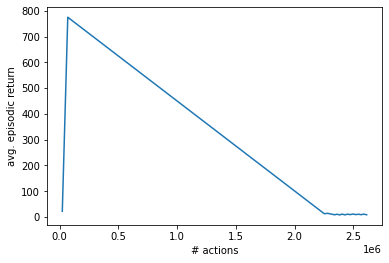

Iteration 19:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.3 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.4 | a_k(R): 9.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.65 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.85 | a_k(R): 8.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.35 | a_k(R): 8.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.4 | a_k(R): 7.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.75 | a_k(R): 7.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 13.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 10.0 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 13.5 | a_k(R): 10.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.7 | a_k(R): 9.65 | sig: Yes
state: [0.0520

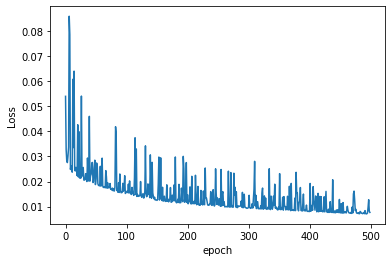

Evaluations...


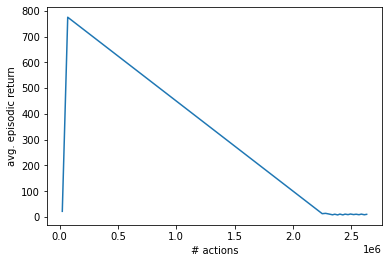

Iteration 20:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.85 | a_k(R): 10.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.6 | a_k(R): 11.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 12.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.55 | a_k(R): 11.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.55 | a_k(R): 13.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.5 | a_k(R): 13.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 10.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.1 | a_k(R): 9.9 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.65 | a_k(R): 10.0 | sig: Yes
state: [0.

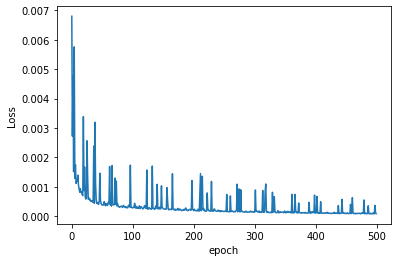

Evaluations...


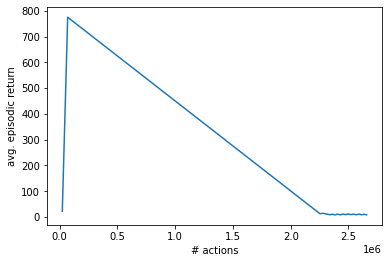

Iteration 21:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.4 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 9.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.8 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.1 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.8 | a_k(R): 9.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.45 | a_k(R): 9.4 | sig: Yes
state: [0.0520

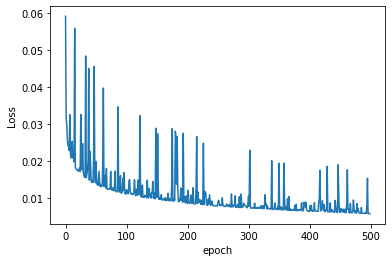

Evaluations...


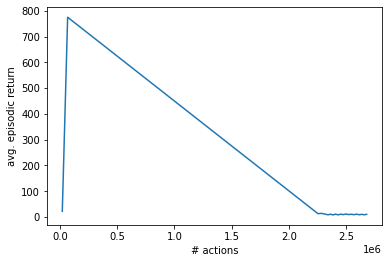

Iteration 22:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.35 | a_k(R): 10.45 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.15 | a_k(R): 11.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 11.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.55 | a_k(R): 11.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.4 | a_k(R): 12.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.5 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.65 | a_k(R): 9.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.85 | a_k(R): 9.8 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.2 | a_k(R): 9.85 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.6 | a_k(R): 10.6 | sig: Yes
state: [0

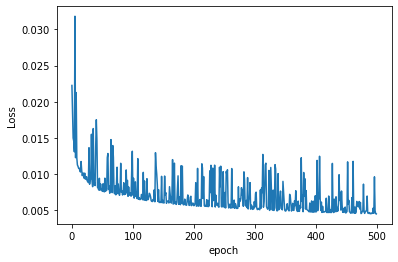

Evaluations...


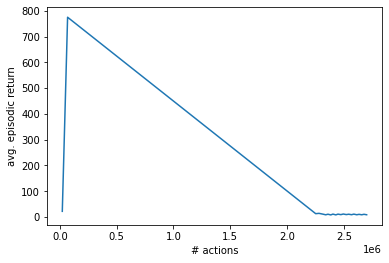

Iteration 23:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.7 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.2 | a_k(R): 10.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.3 | a_k(R): 8.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.2 | a_k(R): 8.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.95 | a_k(R): 9.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.8 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.95 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.05 | a_k(R): 15.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.1 | a_k(R): 10.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 14.25 | a_k(R): 10.15 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.3 | a_k(R): 9.95 | sig: Yes
state: [0.05208

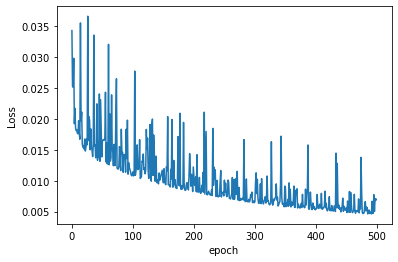

Evaluations...


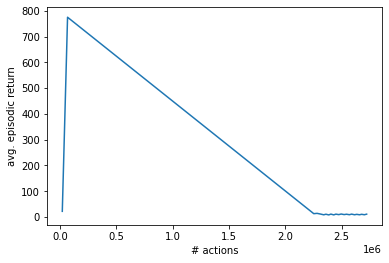

Iteration 24:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 11.0 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.0 | a_k(R): 12.2 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 12.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.05 | a_k(R): 11.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 13.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.0 | a_k(R): 13.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 9.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 10.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.6 | a_k(R): 10.5 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.5 | a_k(R): 11.05 | sig: Yes
state: [

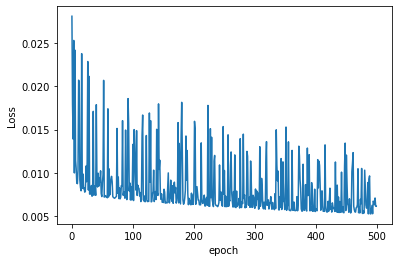

Evaluations...


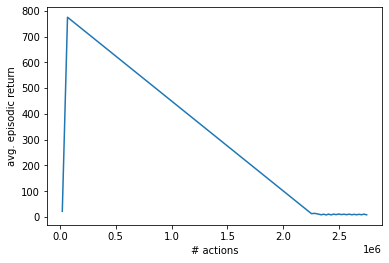

Iteration 25:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.9 | a_k(R): 5.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.75 | a_k(R): 6.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 9.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.4 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 8.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.1 | a_k(R): 12.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.25 | a_k(R): 9.5 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.5 | a_k(R): 9.3 | sig: Yes
state: [0.0520842

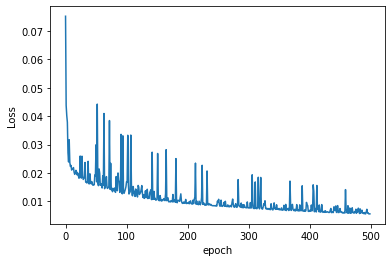

Evaluations...


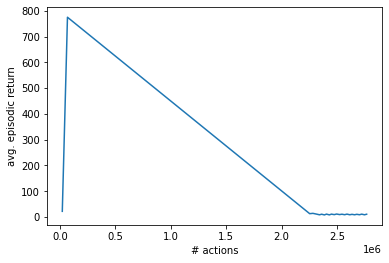

Iteration 26:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 10.85 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.5 | a_k(R): 12.2 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.95 | a_k(R): 12.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.05 | a_k(R): 11.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 13.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 9.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.85 | a_k(R): 10.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.75 | a_k(R): 10.15 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.1 | a_k(R): 10.7 | sig: Yes
stat

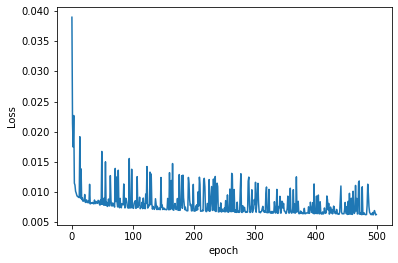

Evaluations...


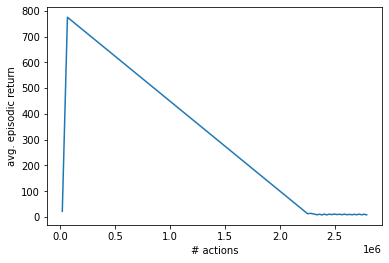

Iteration 27:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 9.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.4 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.25 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.1 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.65 | a_k(R): 13.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.65 | a_k(R): 9.7 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 13.5 | a_k(R): 9.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.65 | a_k(R): 9.15 | sig: Yes
state: [0.05208425

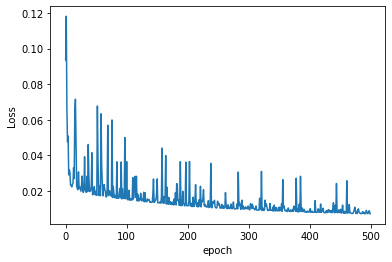

Evaluations...


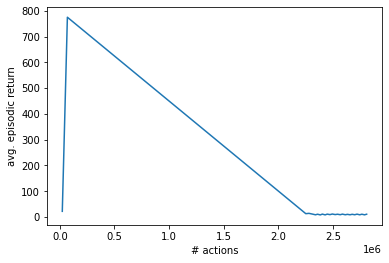

Iteration 28:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.7 | a_k(R): 10.95 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 12.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 12.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 11.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 13.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.7 | a_k(R): 13.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 10.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.55 | a_k(R): 10.1 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.5 | a_k(R): 10.8 | sig: --
state: [0.0

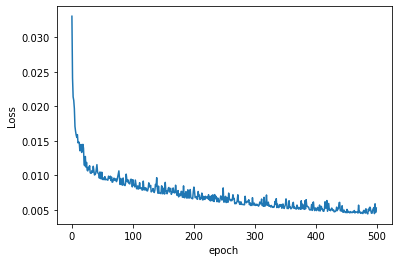

Evaluations...


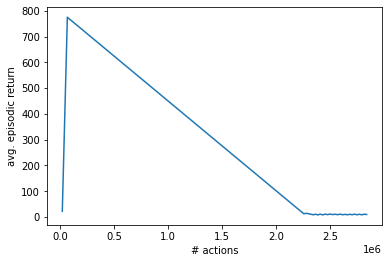

Iteration 29:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.85 | a_k(R): 6.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 15.1 | a_k(R): 11.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.65 | a_k(R): 9.15 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 9.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 9.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.85 | a_k(R): 8.85 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.7 | a_k(R): 8.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 14.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.4 | a_k(R): 11.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 14.7 | a_k(R): 11.25 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 14.1 | a_k(R): 10.7 | sig: Yes
state:

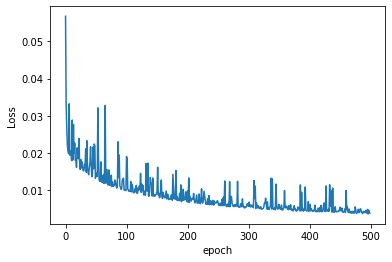

Evaluations...


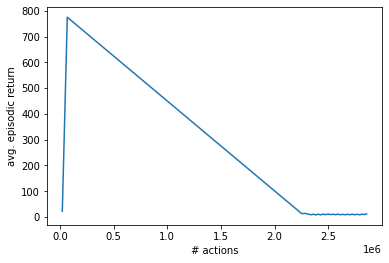

Iteration 30:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.55 | a_k(R): 12.15 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.55 | a_k(R): 13.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.85 | a_k(R): 13.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.9 | a_k(R): 13.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.75 | a_k(R): 14.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.7 | a_k(R): 14.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.1 | a_k(R): 10.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 11.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.55 | a_k(R): 11.5 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.6 | a_k(R): 11.95 | sig: --
sta

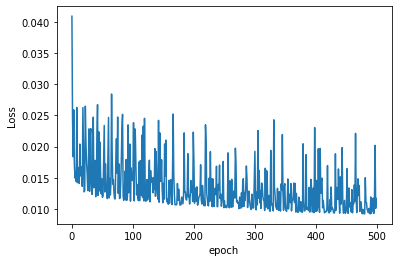

Evaluations...


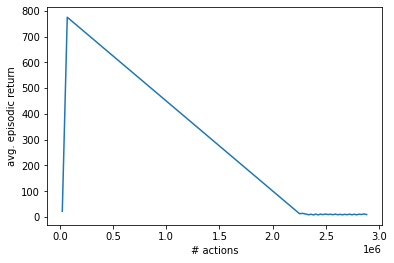

Iteration 31:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.5 | a_k(R): 10.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.4 | a_k(R): 9.15 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.4 | a_k(R): 9.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.2 | a_k(R): 9.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.35 | a_k(R): 8.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.3 | a_k(R): 8.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 14.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 10.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 14.75 | a_k(R): 10.6 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.65 | a_k(R): 10.2 | sig: Yes
state: [0.0

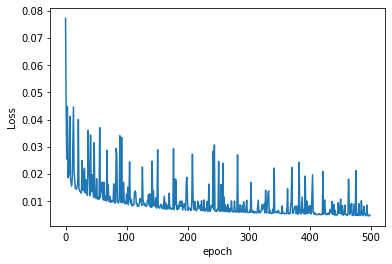

Evaluations...


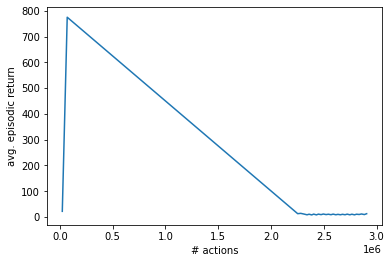

Iteration 32:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.6 | a_k(R): 13.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.55 | a_k(R): 14.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.85 | a_k(R): 14.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 13.2 | a_k(R): 13.85 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 13.15 | a_k(R): 15.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 14.2 | a_k(R): 15.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 12.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 12.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 11.95 | a_k(R): 12.25 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 12.0 | a_k(R): 12.8 | sig: Yes
st

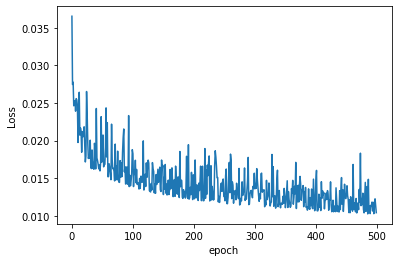

Evaluations...


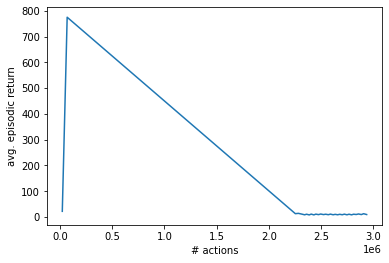

Iteration 33:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 5.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 16.75 | a_k(R): 11.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 16.4 | a_k(R): 9.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.5 | a_k(R): 9.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.25 | a_k(R): 10.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.1 | a_k(R): 9.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.95 | a_k(R): 9.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 7.7 | a_k(R): 17.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 7.75 | a_k(R): 11.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 16.95 | a_k(R): 11.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 15.4 | a_k(R): 11.4 | sig: Yes
state: 

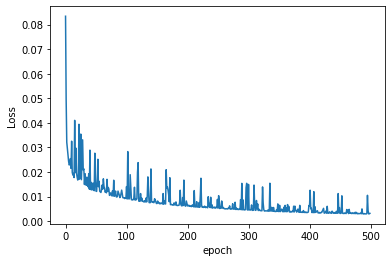

Evaluations...


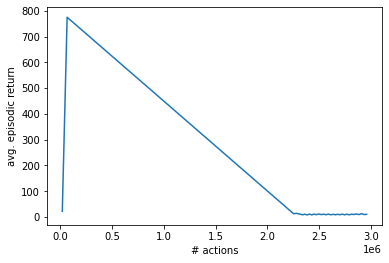

Iteration 34:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.05 | a_k(R): 10.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.95 | a_k(R): 11.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.6 | a_k(R): 11.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.55 | a_k(R): 11.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.5 | a_k(R): 13.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.45 | a_k(R): 13.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.2 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 8.7 | a_k(R): 9.8 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.25 | a_k(R): 9.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.7 | a_k(R): 10.15 | sig: Yes
state: [0.0

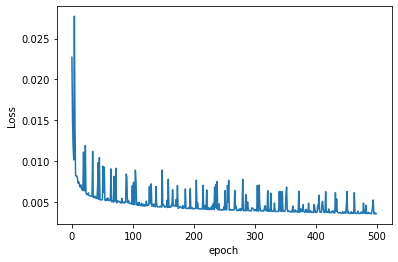

Evaluations...


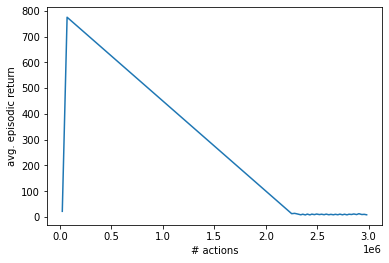

Iteration 35:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.85 | a_k(R): 9.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.8 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.4 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.25 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 13.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.15 | a_k(R): 9.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.35 | a_k(R): 9.05 | sig: Yes
state: [0.05208

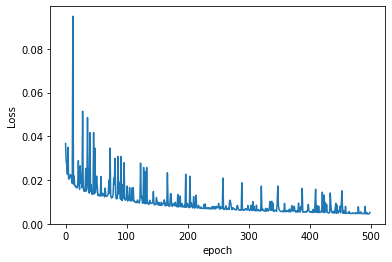

Evaluations...


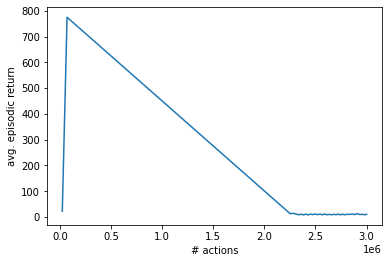

Iteration 36:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.5 | a_k(R): 10.85 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 11.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.95 | a_k(R): 12.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 11.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.8 | a_k(R): 13.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 13.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 10.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.65 | a_k(R): 10.25 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.15 | a_k(R): 10.8 | sig: Yes
state: [

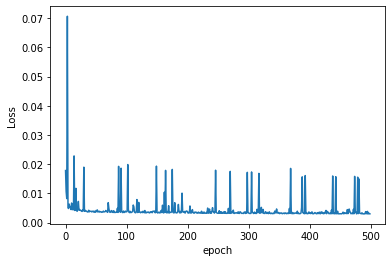

Evaluations...


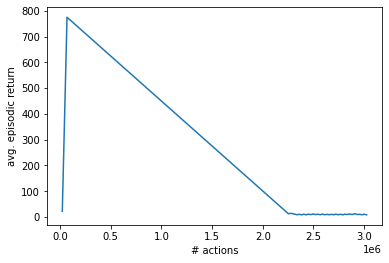

Iteration 37:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 9.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.65 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.05 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 13.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 9.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.2 | a_k(R): 9.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.35 | a_k(R): 9.15 | sig: Yes
state: [0.05208

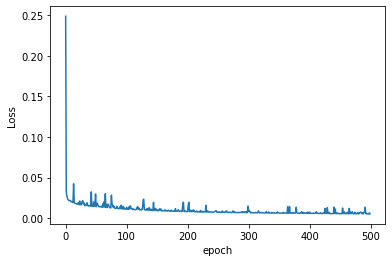

Evaluations...


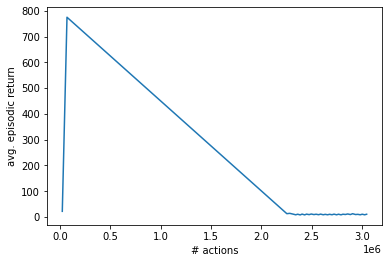

Iteration 38:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.4 | a_k(R): 10.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 11.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.8 | a_k(R): 11.95 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 11.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 13.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.7 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.65 | a_k(R): 10.05 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.1 | a_k(R): 10.7 | sig: Yes
state:

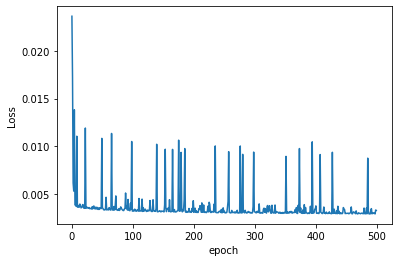

Evaluations...


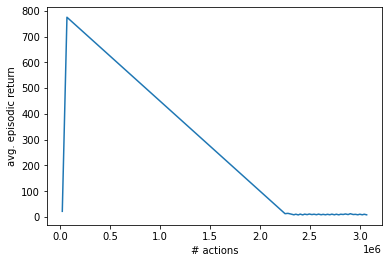

Iteration 39:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.85 | a_k(R): 9.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.45 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.9 | a_k(R): 13.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 9.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.6 | a_k(R): 9.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.6 | a_k(R): 9.25 | sig: Yes
state: [0.052084

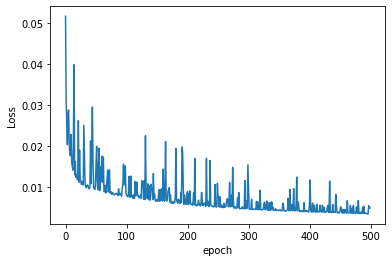

Evaluations...


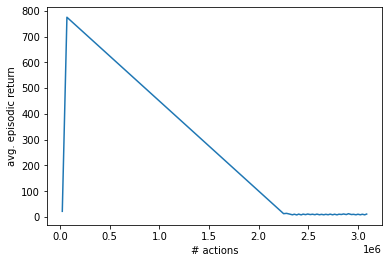

Iteration 40:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 11.3 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.3 | a_k(R): 12.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.7 | a_k(R): 12.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.3 | a_k(R): 12.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.25 | a_k(R): 14.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.45 | a_k(R): 14.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.5 | a_k(R): 10.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.5 | a_k(R): 11.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 11.2 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.05 | a_k(R): 11.25 | sig: --
state: [

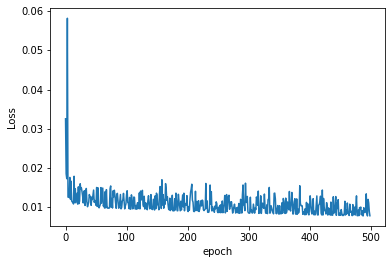

Evaluations...


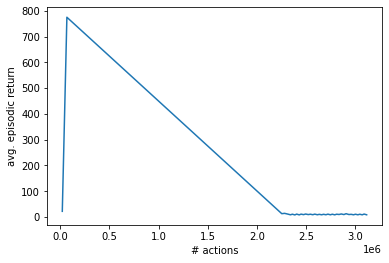

Iteration 41:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 9.35 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.0 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.4 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.4 | a_k(R): 13.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.5 | a_k(R): 9.6 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.7 | a_k(R): 9.25 | sig: Yes
state: [0.0520842

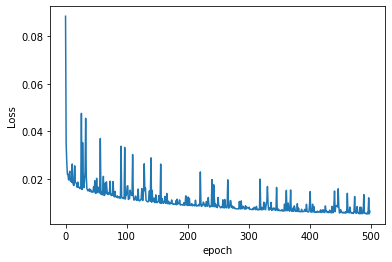

Evaluations...


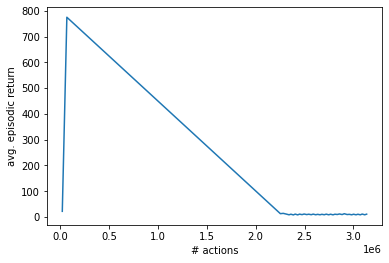

Iteration 42:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 11.15 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.8 | a_k(R): 12.35 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.3 | a_k(R): 12.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 12.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.25 | a_k(R): 13.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.75 | a_k(R): 14.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.45 | a_k(R): 9.9 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 9.45 | a_k(R): 10.8 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 10.9 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.35 | a_k(R): 11.2 | sig: Yes
state: 

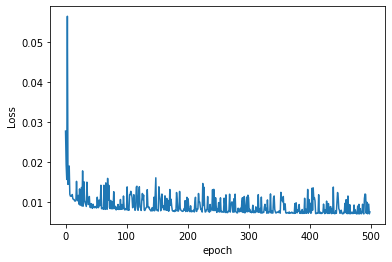

Evaluations...


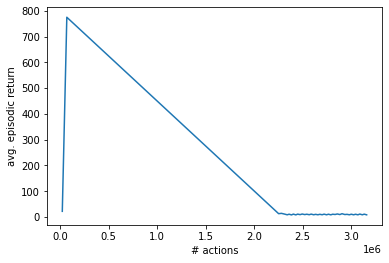

Iteration 43:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 9.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.55 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 8.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.05 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.9 | a_k(R): 13.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 9.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.4 | a_k(R): 9.5 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.5 | a_k(R): 9.25 | sig: Yes
state: [0.05208425

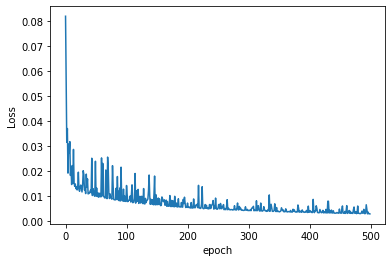

Evaluations...


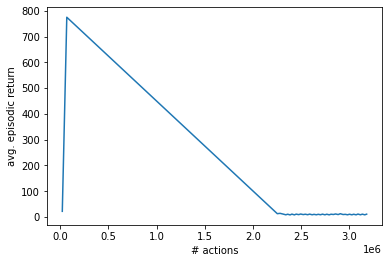

Iteration 44:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 11.2 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 12.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.0 | a_k(R): 12.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 12.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 13.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.0 | a_k(R): 13.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 9.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 10.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.8 | a_k(R): 10.6 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.45 | a_k(R): 11.1 | sig: Yes
state: [0.

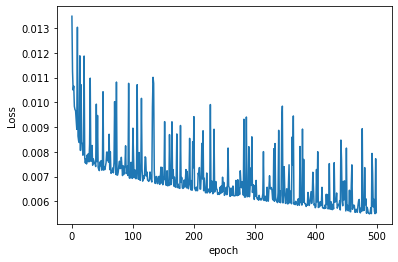

Evaluations...


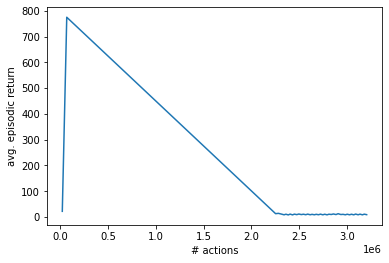

Iteration 45:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.95 | a_k(R): 5.5 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.7 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.6 | a_k(R): 10.2 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.75 | a_k(R): 8.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.25 | a_k(R): 8.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 9.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.1 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 14.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 10.1 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 14.35 | a_k(R): 10.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.05 | a_k(R): 10.15 | sig: Yes
state: [0.

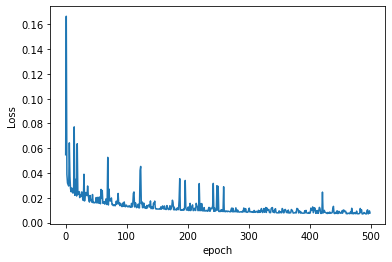

Evaluations...


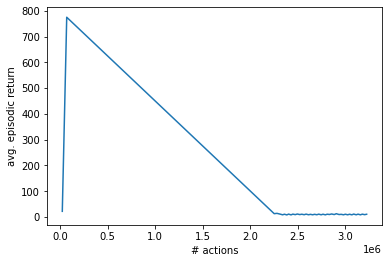

Iteration 46:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 10.75 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 11.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.7 | a_k(R): 11.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.75 | a_k(R): 11.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.4 | a_k(R): 13.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.6 | a_k(R): 13.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 9.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.85 | a_k(R): 9.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.3 | a_k(R): 10.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.4 | a_k(R): 10.65 | sig: --
state: [0

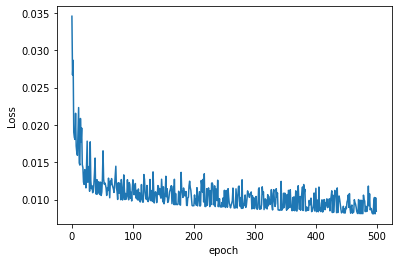

Evaluations...


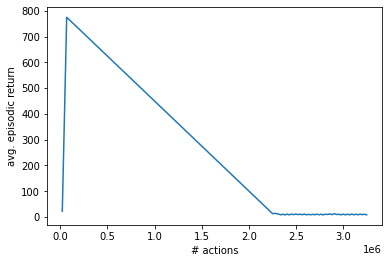

Iteration 47:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.5 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.8 | a_k(R): 6.1 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 9.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.35 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.5 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.3 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 13.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.1 | a_k(R): 9.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.35 | a_k(R): 9.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.4 | a_k(R): 9.2 | sig: Yes
state: [0.05208425

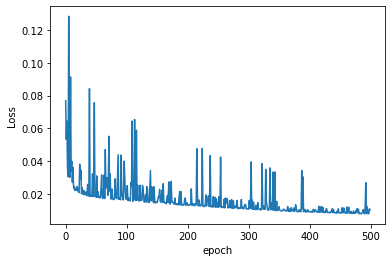

Evaluations...


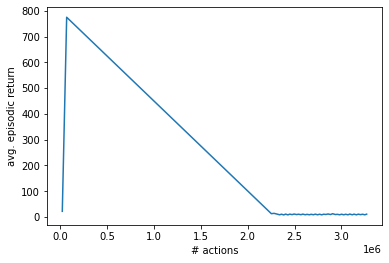

Iteration 48:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.75 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.75 | a_k(R): 11.0 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.0 | a_k(R): 12.15 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.1 | a_k(R): 12.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.05 | a_k(R): 12.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.95 | a_k(R): 13.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.05 | a_k(R): 13.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 9.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 10.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.95 | a_k(R): 10.6 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.55 | a_k(R): 11.1 | sig: Yes
stat

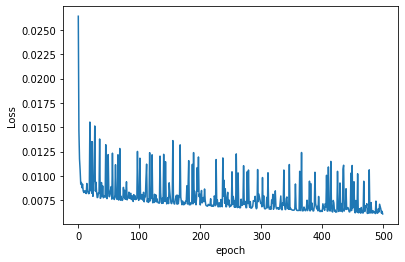

Evaluations...


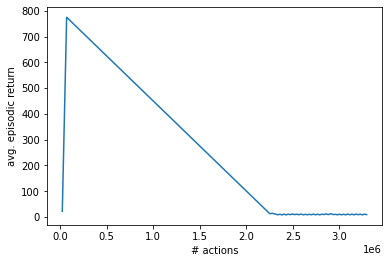

Iteration 49:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.8 | a_k(R): 5.45 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.65 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.6 | a_k(R): 6.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.95 | a_k(R): 10.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.3 | a_k(R): 8.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.45 | a_k(R): 8.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 9.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.1 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.1 | a_k(R): 14.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 10.4 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 14.7 | a_k(R): 10.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.35 | a_k(R): 10.05 | sig: Yes
state: [0.

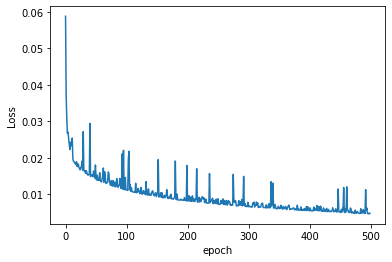

Evaluations...


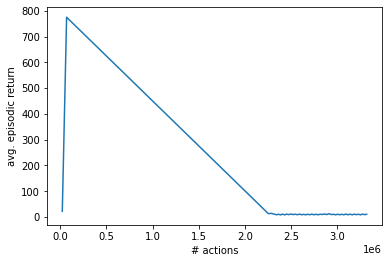

Iteration 50:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.65 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.8 | a_k(R): 6.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.4 | a_k(R): 10.7 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 12.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 12.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.5 | a_k(R): 11.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.65 | a_k(R): 13.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.35 | a_k(R): 13.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 9.05 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 9.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 9.9 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.05 | a_k(R): 10.5 | sig: --
state: [0.0

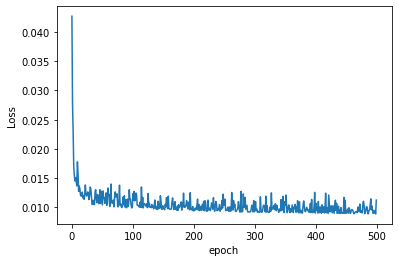

Evaluations...


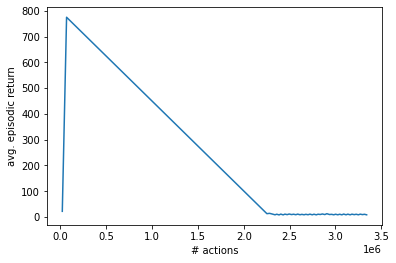

Iteration 51:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 9.35 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.45 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.15 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.1 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.25 | a_k(R): 9.55 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.35 | a_k(R): 9.05 | sig: Yes
state: [0.052

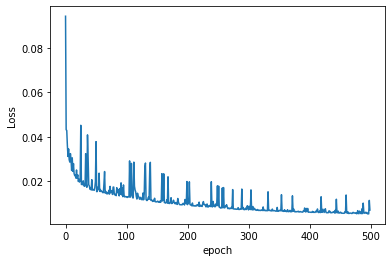

Evaluations...


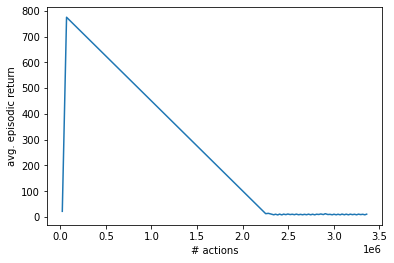

Iteration 52:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 11.15 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 12.35 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.15 | a_k(R): 12.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.95 | a_k(R): 11.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 13.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.85 | a_k(R): 13.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 9.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.9 | a_k(R): 10.6 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.4 | a_k(R): 10.95 | sig: Yes
sta

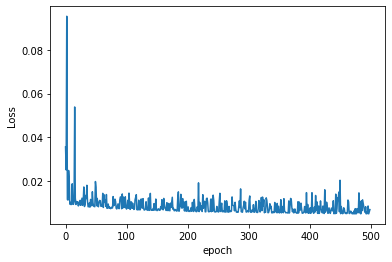

Evaluations...


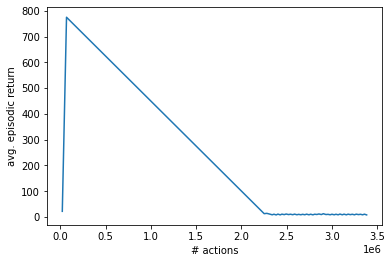

Iteration 53:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 9.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.5 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.05 | a_k(R): 12.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.15 | a_k(R): 9.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.35 | a_k(R): 9.5 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.55 | a_k(R): 9.1 | sig: Yes
state: [0.052084

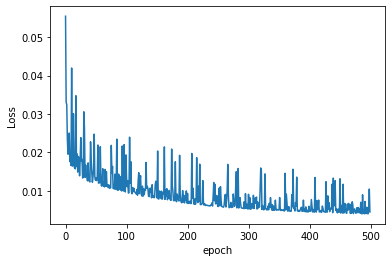

Evaluations...


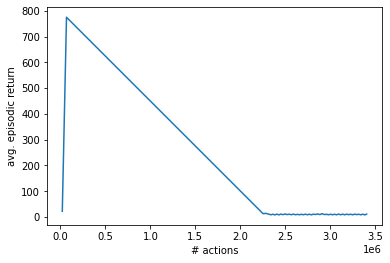

Iteration 54:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.25 | a_k(R): 11.4 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.3 | a_k(R): 12.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.5 | a_k(R): 12.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.35 | a_k(R): 12.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.2 | a_k(R): 14.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.45 | a_k(R): 13.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.25 | a_k(R): 9.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.25 | a_k(R): 11.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 10.9 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.05 | a_k(R): 11.75 | sig: Yes
state

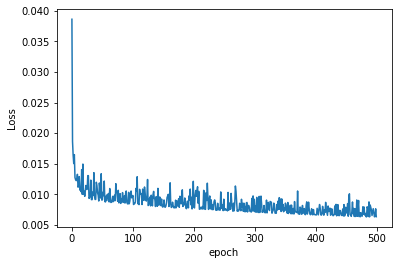

Evaluations...


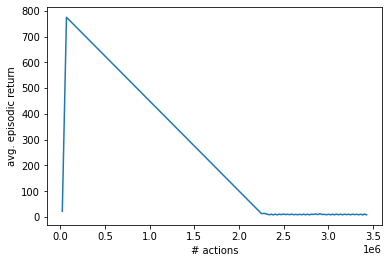

Iteration 55:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 9.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.5 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.95 | a_k(R): 13.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.75 | a_k(R): 9.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.75 | a_k(R): 9.2 | sig: Yes
state: [0.052084252

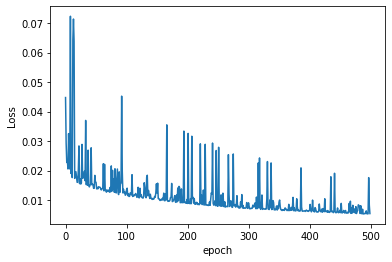

Evaluations...


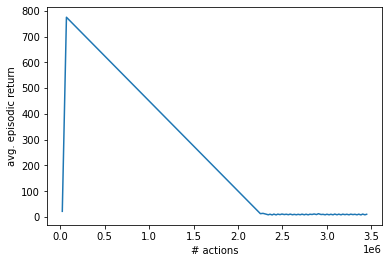

Iteration 56:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.15 | a_k(R): 10.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.1 | a_k(R): 11.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 11.85 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.7 | a_k(R): 11.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.55 | a_k(R): 13.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.4 | a_k(R): 13.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 9.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.2 | a_k(R): 10.1 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.75 | a_k(R): 10.6 | sig: Yes
state: [0.

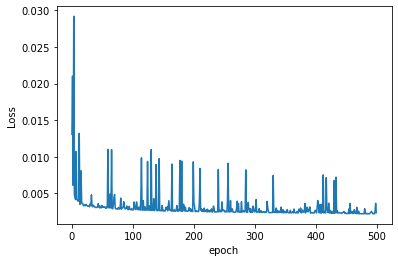

Evaluations...


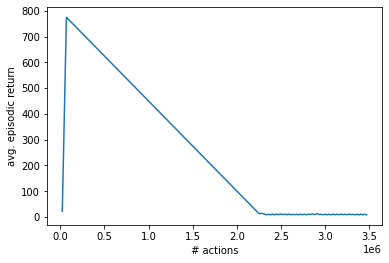

Iteration 57:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.05 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.95 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.7 | a_k(R): 9.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.75 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.75 | a_k(R): 13.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.75 | a_k(R): 9.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.65 | a_k(R): 9.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.4 | a_k(R): 9.35 | sig: Yes
state: [0.0520842

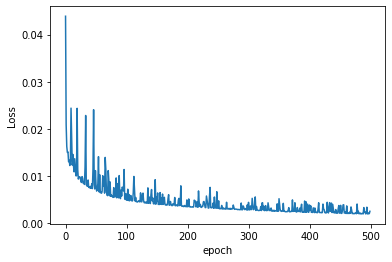

Evaluations...


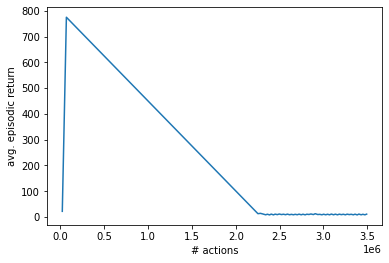

Iteration 58:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 11.3 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.95 | a_k(R): 12.2 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.0 | a_k(R): 12.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 12.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 13.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.2 | a_k(R): 13.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 9.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 10.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.95 | a_k(R): 10.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.75 | a_k(R): 11.25 | sig: Yes
state

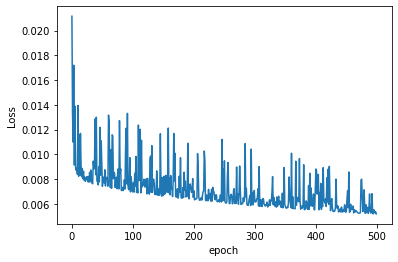

Evaluations...


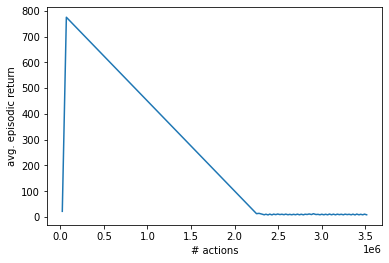

Iteration 59:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.4 | a_k(R): 9.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.45 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 13.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 9.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.05 | a_k(R): 9.5 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.5 | a_k(R): 9.25 | sig: Yes
state: [0.05

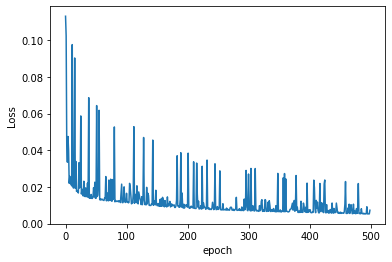

Evaluations...


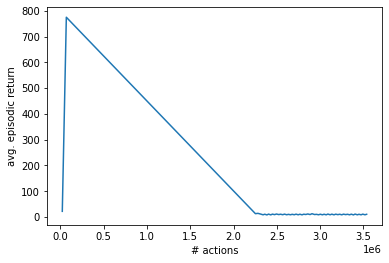

Iteration 60:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.9 | a_k(R): 10.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.85 | a_k(R): 11.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 11.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.75 | a_k(R): 11.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.8 | a_k(R): 13.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.55 | a_k(R): 13.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 9.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 10.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.45 | a_k(R): 10.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.95 | a_k(R): 10.35 | sig: Yes
state: [

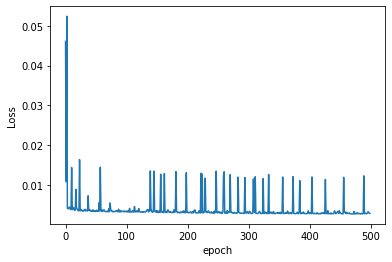

Evaluations...


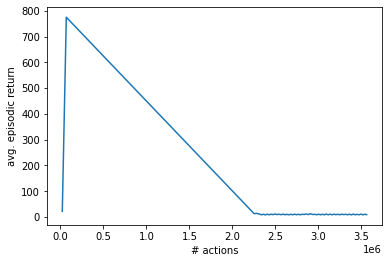

Iteration 61:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.9 | a_k(R): 10.2 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.9 | a_k(R): 8.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.25 | a_k(R): 8.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.55 | a_k(R): 9.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.8 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.1 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 13.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 10.35 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 14.1 | a_k(R): 10.2 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.05 | a_k(R): 10.0 | sig: Yes
state: [0.052

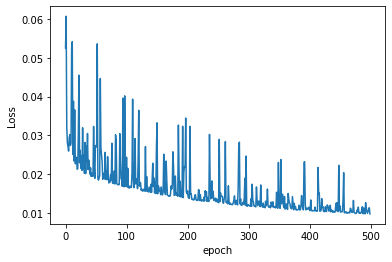

Evaluations...


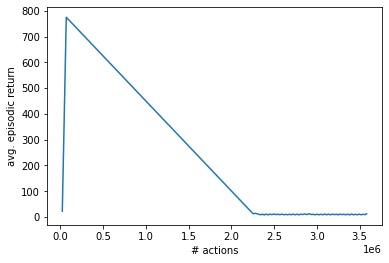

Iteration 62:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.2 | a_k(R): 13.0 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 12.1 | a_k(R): 14.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.3 | a_k(R): 13.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.75 | a_k(R): 14.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.7 | a_k(R): 15.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 13.2 | a_k(R): 15.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 11.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 12.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 11.35 | a_k(R): 11.85 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 11.5 | a_k(R): 12.3 | sig: Yes
state: 

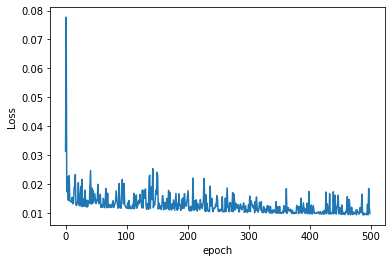

Evaluations...


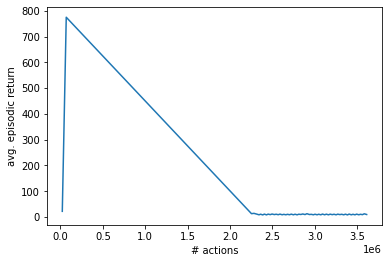

Iteration 63:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.85 | a_k(R): 10.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.75 | a_k(R): 9.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 9.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.55 | a_k(R): 9.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.45 | a_k(R): 8.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.7 | a_k(R): 8.8 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 15.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 11.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 15.1 | a_k(R): 11.1 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 14.25 | a_k(R): 10.85 | sig: Yes
state: [

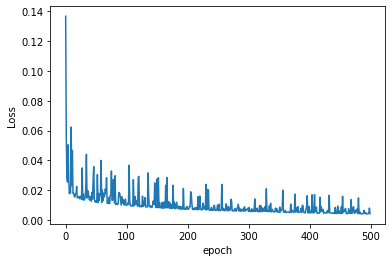

Evaluations...


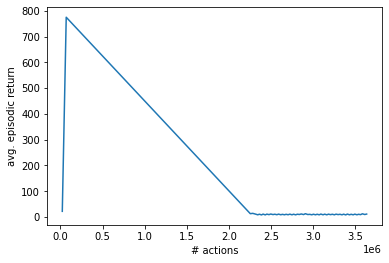

Iteration 64:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.85 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.3 | a_k(R): 11.35 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.95 | a_k(R): 12.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.65 | a_k(R): 12.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.55 | a_k(R): 12.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 14.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.25 | a_k(R): 14.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.4 | a_k(R): 10.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.35 | a_k(R): 11.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 10.95 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.25 | a_k(R): 11.55 | sig: --
sta

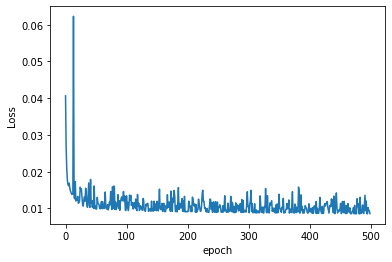

Evaluations...


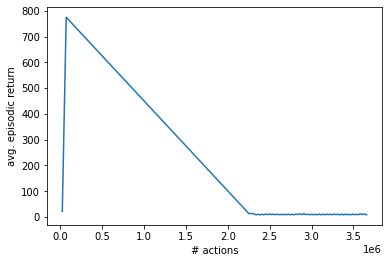

Iteration 65:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.4 | a_k(R): 5.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.35 | a_k(R): 9.35 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.45 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.1 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 13.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.4 | a_k(R): 9.6 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.45 | a_k(R): 9.4 | sig: Yes
state: [0.0

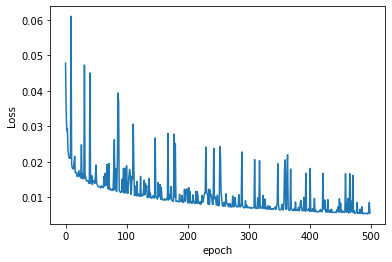

Evaluations...


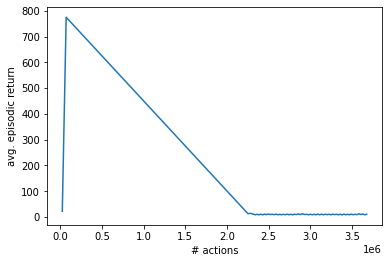

Iteration 66:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.6 | a_k(R): 11.0 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 12.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 12.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.95 | a_k(R): 11.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 13.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 13.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 10.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.5 | a_k(R): 10.15 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.15 | a_k(R): 10.75 | sig: Yes
state: [

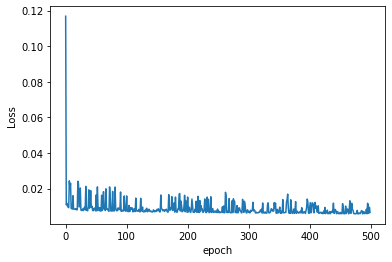

Evaluations...


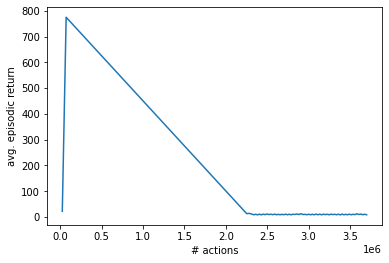

Iteration 67:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.8 | a_k(R): 5.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.5 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.65 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.3 | a_k(R): 9.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.3 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.1 | a_k(R): 13.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 9.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.75 | a_k(R): 9.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.6 | a_k(R): 9.05 | sig: Yes
state: [0.052084

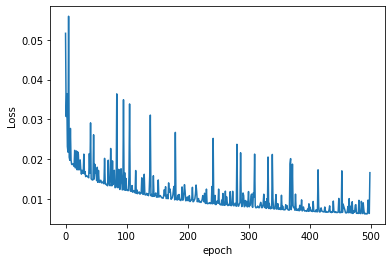

Evaluations...


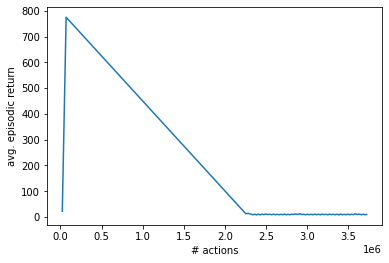

Iteration 68:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.0 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 9.0 | a_k(R): 10.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.05 | a_k(R): 11.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.15 | a_k(R): 11.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 11.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.2 | a_k(R): 13.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 13.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.2 | a_k(R): 8.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.2 | a_k(R): 9.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 9.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.15 | a_k(R): 9.7 | sig: Yes
state: [0.05208425

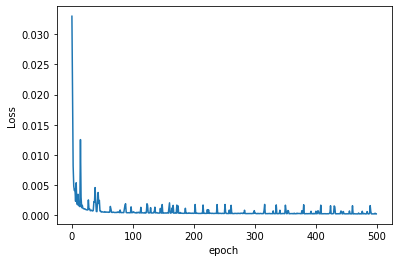

Evaluations...


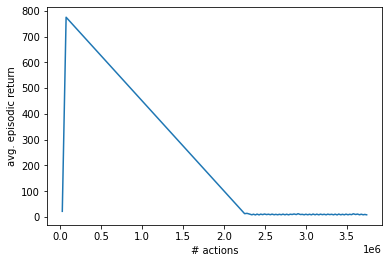

Iteration 69:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.45 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 9.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.85 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.2 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 13.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.9 | a_k(R): 9.45 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 13.85 | a_k(R): 9.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.45 | a_k(R): 9.15 | sig: Yes
state: [0.05208

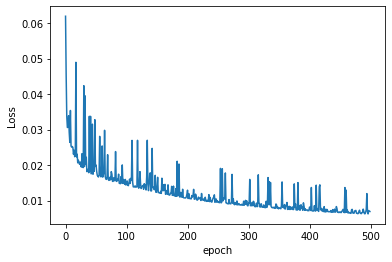

Evaluations...


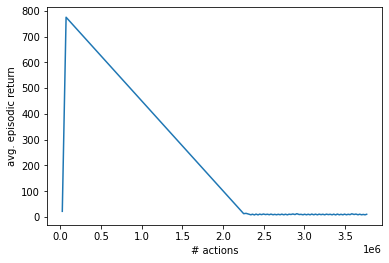

Iteration 70:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.45 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.75 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.35 | a_k(R): 10.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.25 | a_k(R): 11.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.8 | a_k(R): 12.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.55 | a_k(R): 11.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.35 | a_k(R): 13.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.4 | a_k(R): 13.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.75 | a_k(R): 9.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.85 | a_k(R): 9.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.1 | a_k(R): 10.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.75 | a_k(R): 10.7 | sig: Yes
state: [

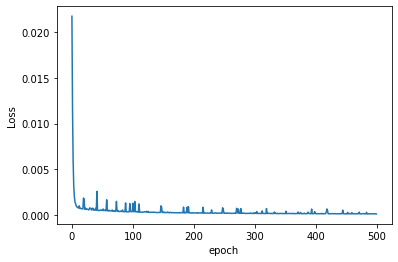

Evaluations...


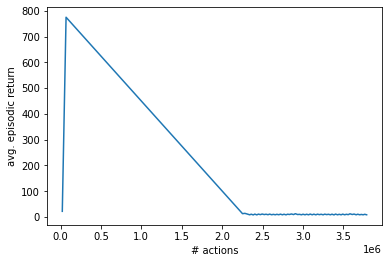

Iteration 71:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 5.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.6 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 9.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.5 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.8 | a_k(R): 9.55 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.4 | a_k(R): 9.2 | sig: Yes
state: [0.05

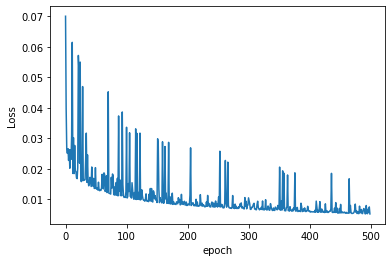

Evaluations...


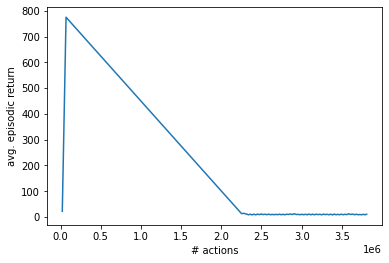

Iteration 72:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.6 | a_k(R): 10.9 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 12.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 12.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 11.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.75 | a_k(R): 13.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.0 | a_k(R): 13.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 10.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.8 | a_k(R): 10.2 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.15 | a_k(R): 10.75 | sig: Yes
state: 

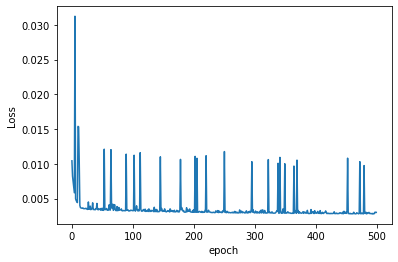

Evaluations...


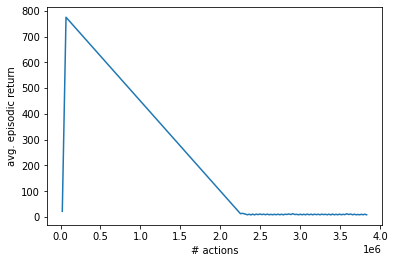

Iteration 73:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.5 | a_k(R): 5.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.65 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.95 | a_k(R): 9.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.55 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.4 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.05 | a_k(R): 9.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.5 | a_k(R): 9.3 | sig: Yes
state: [0.0

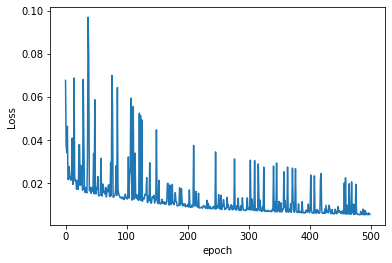

Evaluations...


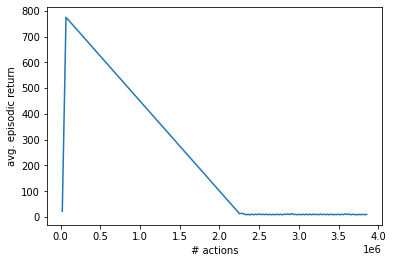

Iteration 74:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.0 | a_k(R): 10.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.8 | a_k(R): 11.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.75 | a_k(R): 11.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.65 | a_k(R): 11.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.65 | a_k(R): 13.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.7 | a_k(R): 13.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.7 | a_k(R): 9.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.4 | a_k(R): 9.95 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.0 | a_k(R): 10.25 | sig: --
state: [0.05

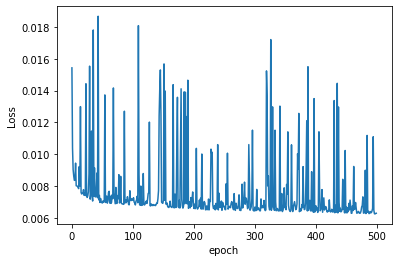

Evaluations...


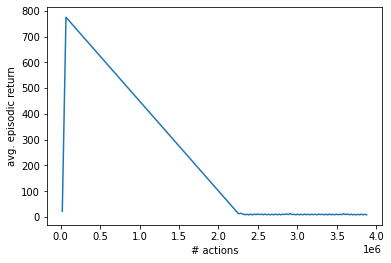

Iteration 75:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.8 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.85 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.3 | a_k(R): 9.75 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.35 | a_k(R): 8.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.85 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.2 | a_k(R): 8.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.35 | a_k(R): 7.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.25 | a_k(R): 7.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.4 | a_k(R): 13.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 9.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.85 | a_k(R): 9.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.75 | a_k(R): 9.4 | sig: Yes
state: 

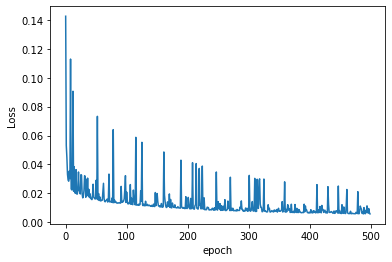

Evaluations...


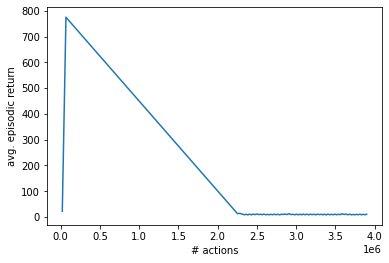

Iteration 76:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 10.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 12.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 12.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 11.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.8 | a_k(R): 13.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.85 | a_k(R): 13.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.6 | a_k(R): 10.2 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.15 | a_k(R): 10.85 | sig: Yes
state

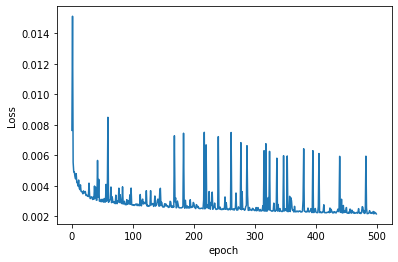

Evaluations...


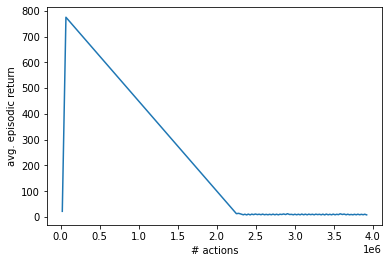

Iteration 77:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 5.0 | sig: --
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 9.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.7 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.65 | a_k(R): 13.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 9.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.2 | a_k(R): 9.65 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.45 | a_k(R): 9.1 | sig: Yes
state: [0.052084252,

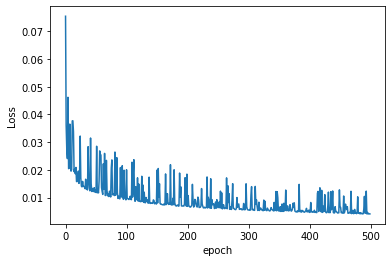

Evaluations...


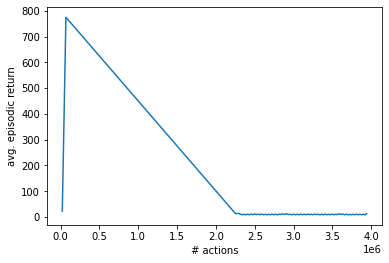

Iteration 78:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 12.95 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 13.65 | a_k(R): 14.1 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 13.95 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 13.35 | a_k(R): 14.1 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 13.1 | a_k(R): 16.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 14.35 | a_k(R): 16.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 12.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 12.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 11.85 | a_k(R): 12.2 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 12.5 | a_k(R): 12.9 | sig: --
state: [0

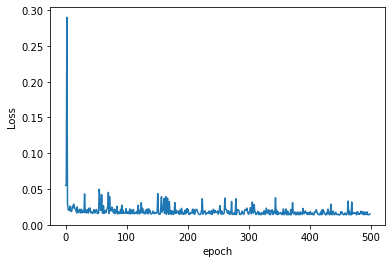

Evaluations...


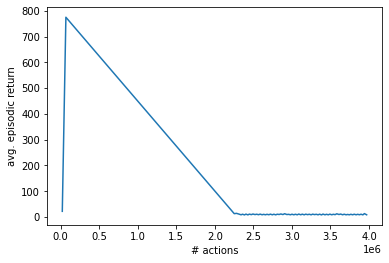

Iteration 79:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.6 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.5 | a_k(R): 6.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 9.35 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.95 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.55 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.05 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 13.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 9.7 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 13.35 | a_k(R): 9.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.55 | a_k(R): 9.15 | sig: Yes
state: [0.05

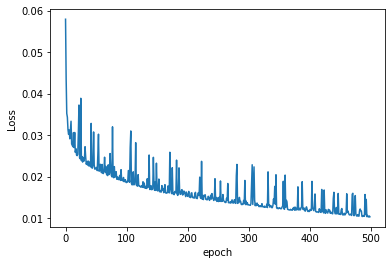

Evaluations...


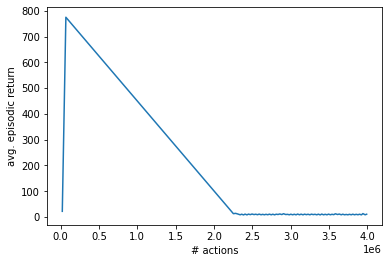

Iteration 80:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 11.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.4 | a_k(R): 12.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.2 | a_k(R): 12.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 11.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 13.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.6 | a_k(R): 13.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.65 | a_k(R): 9.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.6 | a_k(R): 10.05 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.0 | a_k(R): 10.7 | sig: Yes
state

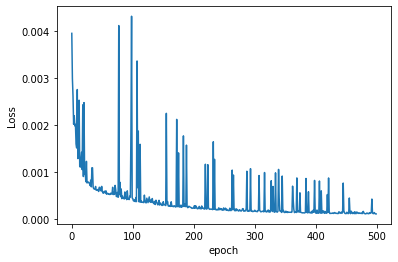

Evaluations...


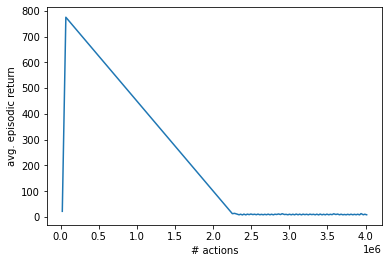

Iteration 81:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 5.6 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.8 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 9.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.35 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.4 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 13.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 9.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.1 | a_k(R): 9.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.3 | a_k(R): 9.35 | sig: Yes
state: [0.052

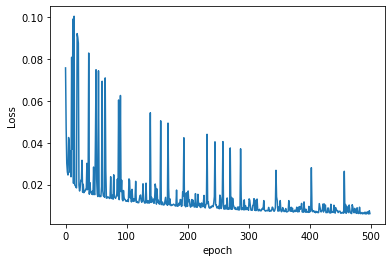

Evaluations...


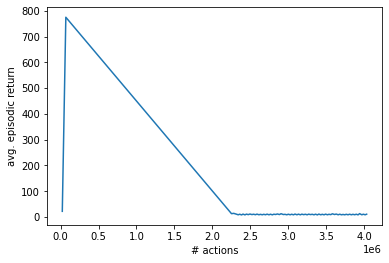

Iteration 82:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.8 | a_k(R): 11.1 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.9 | a_k(R): 12.15 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.1 | a_k(R): 12.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 11.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.15 | a_k(R): 13.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.85 | a_k(R): 13.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 10.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.8 | a_k(R): 10.7 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.25 | a_k(R): 11.0 | sig: Yes
state: [0

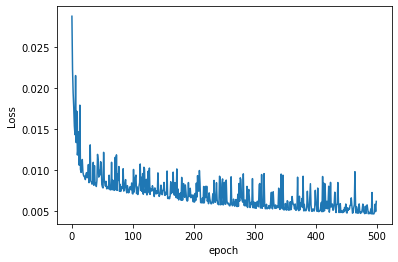

Evaluations...


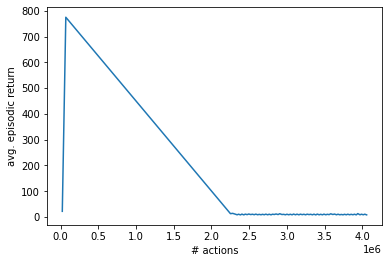

Iteration 83:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.75 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 9.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.65 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.05 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 13.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.1 | a_k(R): 9.6 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.3 | a_k(R): 9.35 | sig: Yes
state: [0.0520842

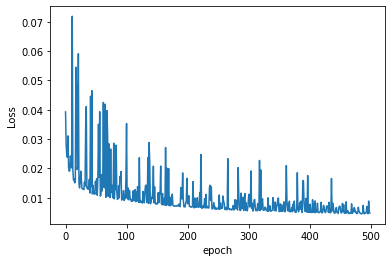

Evaluations...


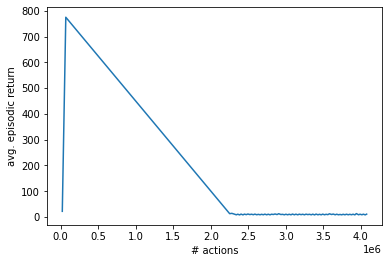

Iteration 84:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.95 | a_k(R): 11.2 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.75 | a_k(R): 12.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 12.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 11.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 13.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.05 | a_k(R): 13.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 9.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 10.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.7 | a_k(R): 10.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.3 | a_k(R): 11.05 | sig: Yes
state: [0.

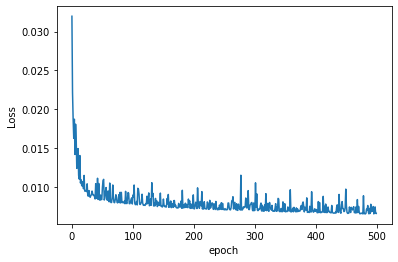

Evaluations...


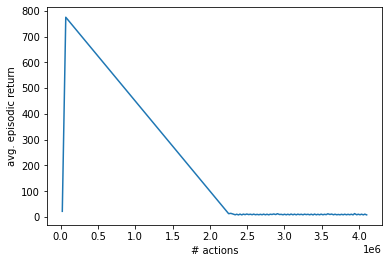

Iteration 85:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.45 | a_k(R): 9.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.3 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.6 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.1 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 13.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 9.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.7 | a_k(R): 9.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.25 | a_k(R): 9.15 | sig: Yes
state: [0.052084252,

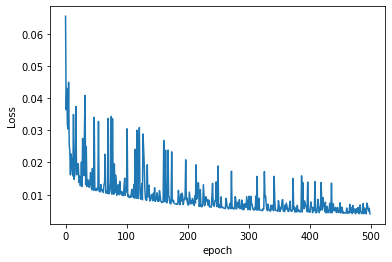

Evaluations...


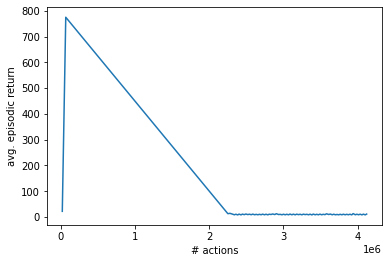

Iteration 86:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.3 | a_k(R): 11.5 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.3 | a_k(R): 12.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.65 | a_k(R): 12.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.45 | a_k(R): 12.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 14.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.4 | a_k(R): 14.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.35 | a_k(R): 9.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.3 | a_k(R): 11.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 11.1 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.15 | a_k(R): 11.55 | sig: --
state:

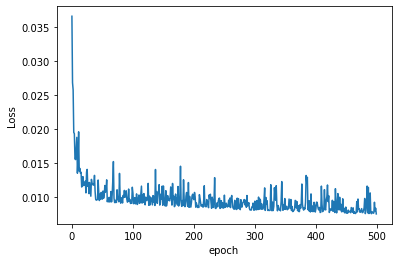

Evaluations...


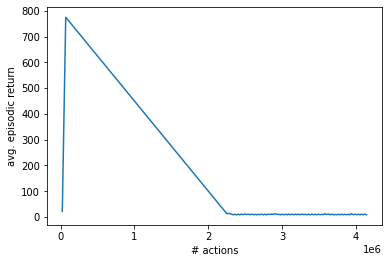

Iteration 87:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.5 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 9.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.4 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.2 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 12.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.5 | a_k(R): 9.5 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.35 | a_k(R): 9.2 | sig: Yes
state: [0.0520842

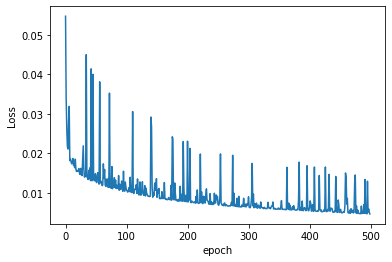

Evaluations...


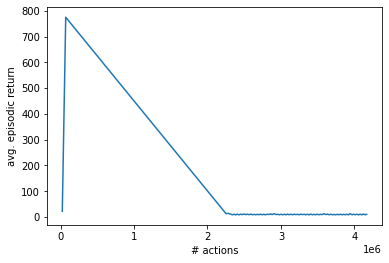

Iteration 88:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.3 | a_k(R): 10.65 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 9.95 | a_k(R): 11.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.45 | a_k(R): 11.85 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.75 | a_k(R): 11.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.7 | a_k(R): 13.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.5 | a_k(R): 13.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.65 | a_k(R): 9.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.2 | a_k(R): 9.85 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 9.9 | a_k(R): 10.4 | sig: Yes
state: [0.

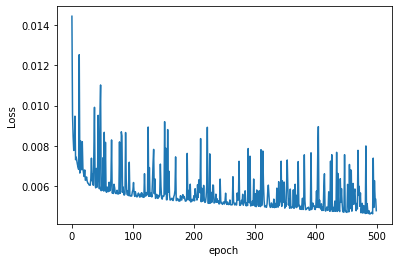

Evaluations...


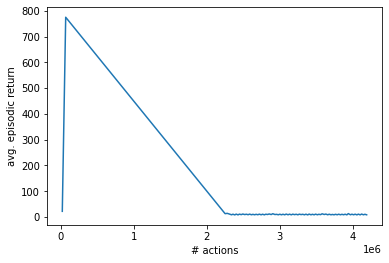

Iteration 89:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.15 | a_k(R): 9.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.05 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.35 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.3 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.8 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.9 | a_k(R): 9.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.5 | a_k(R): 9.35 | sig: Yes
state: [0.05208425

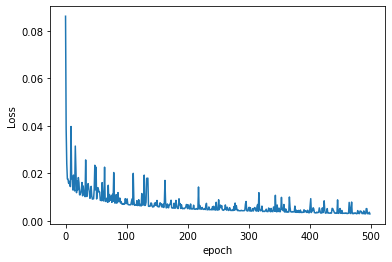

Evaluations...


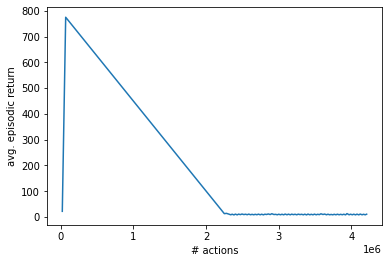

Iteration 90:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.55 | a_k(R): 11.0 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.6 | a_k(R): 12.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.0 | a_k(R): 12.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 11.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 13.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 13.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 10.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.85 | a_k(R): 10.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.45 | a_k(R): 11.3 | sig: Yes
state: [

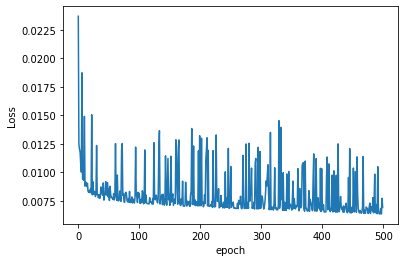

Evaluations...


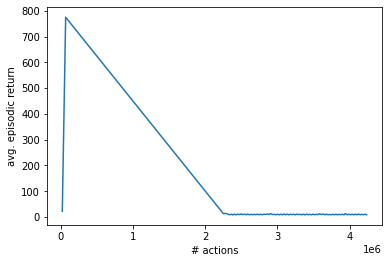

Iteration 91:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.55 | a_k(R): 6.65 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.05 | a_k(R): 6.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.65 | a_k(R): 9.7 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.25 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.65 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.35 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 14.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.95 | a_k(R): 9.85 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 13.45 | a_k(R): 9.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.7 | a_k(R): 9.35 | sig: Yes
state: [

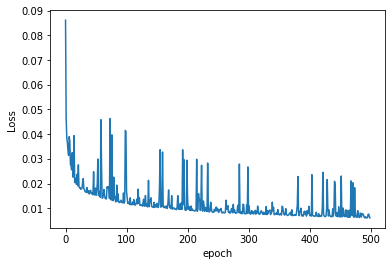

Evaluations...


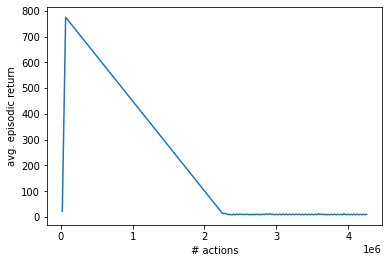

Iteration 92:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.5 | a_k(R): 10.85 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.45 | a_k(R): 12.2 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.0 | a_k(R): 12.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.75 | a_k(R): 11.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.6 | a_k(R): 13.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.6 | a_k(R): 13.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 9.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.95 | a_k(R): 10.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.65 | a_k(R): 10.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.4 | a_k(R): 10.8 | sig: Yes
state: [0.0

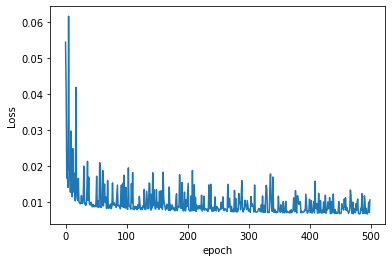

Evaluations...


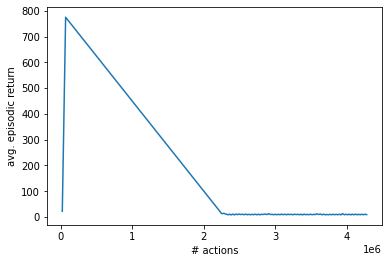

Iteration 93:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.75 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.25 | a_k(R): 10.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.25 | a_k(R): 8.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.35 | a_k(R): 8.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.85 | a_k(R): 9.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.05 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.1 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 14.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 10.55 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 14.35 | a_k(R): 10.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.3 | a_k(R): 10.2 | sig: Yes
state: [0

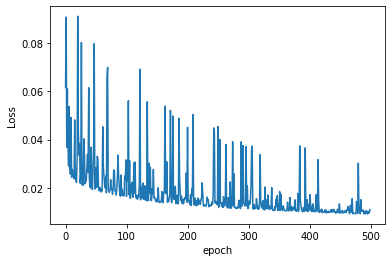

Evaluations...


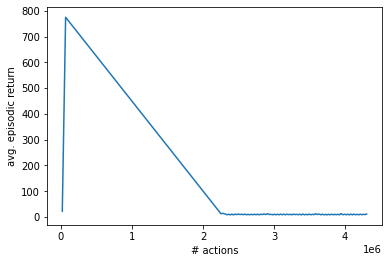

Iteration 94:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.2 | a_k(R): 11.25 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.35 | a_k(R): 12.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.25 | a_k(R): 12.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.35 | a_k(R): 12.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.35 | a_k(R): 13.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.25 | a_k(R): 13.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.3 | a_k(R): 10.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.1 | a_k(R): 11.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 10.95 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.25 | a_k(R): 11.55 | sig: --
state:

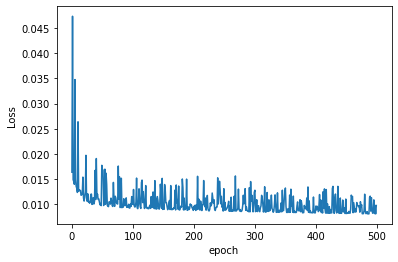

Evaluations...


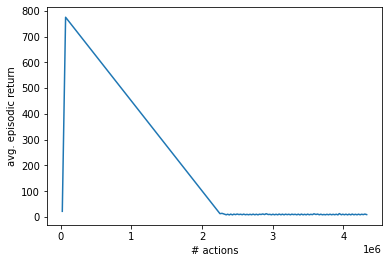

Iteration 95:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.8 | a_k(R): 5.0 | sig: --
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 6.55 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.3 | a_k(R): 10.35 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.95 | a_k(R): 8.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.65 | a_k(R): 8.95 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.15 | a_k(R): 9.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.05 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.2 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 14.75 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 10.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 14.45 | a_k(R): 10.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.45 | a_k(R): 10.25 | sig: Yes
state: 

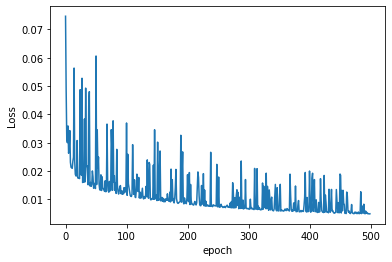

Evaluations...


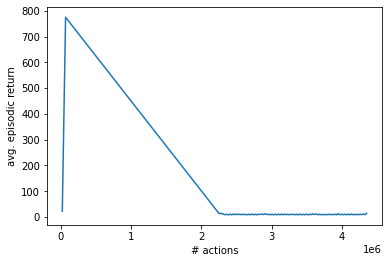

Iteration 96:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.0 | a_k(R): 14.35 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 13.9 | a_k(R): 14.35 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 15.15 | a_k(R): 14.7 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 14.85 | a_k(R): 14.8 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 13.75 | a_k(R): 16.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 17.15 | a_k(R): 17.2 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 11.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 14.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.8 | a_k(R): 13.9 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 12.25 | a_k(R): 13.9 | sig: Yes
state: 

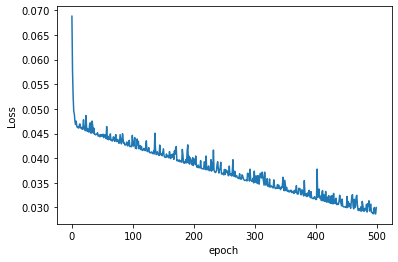

Evaluations...


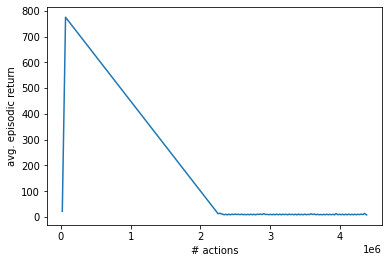

Iteration 97:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 5.0 | sig: --
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.65 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.65 | a_k(R): 9.4 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 9.35 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.7 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.1 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 7.55 | a_k(R): 9.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 7.8 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.25 | a_k(R): 9.45 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 9.8 | a_k(R): 9.1 | sig: Yes
state: [0.052084252, 0.

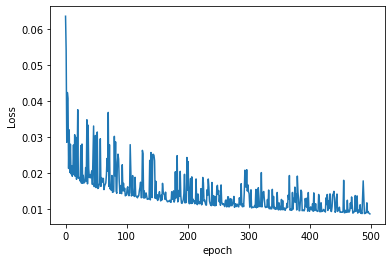

Evaluations...


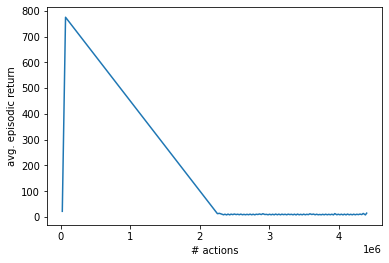

Iteration 98:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.85 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 15.3 | a_k(R): 14.55 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 14.15 | a_k(R): 16.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.8 | a_k(R): 16.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 15.95 | a_k(R): 16.35 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 15.05 | a_k(R): 17.9 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 16.05 | a_k(R): 18.15 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 14.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 14.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 14.05 | a_k(R): 13.5 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 15.6 | a_k(R): 14.35 | sig: --
s

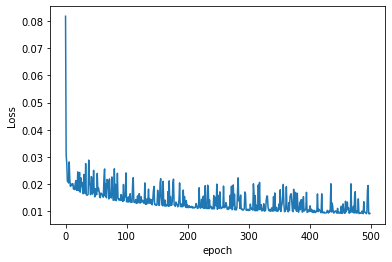

Evaluations...


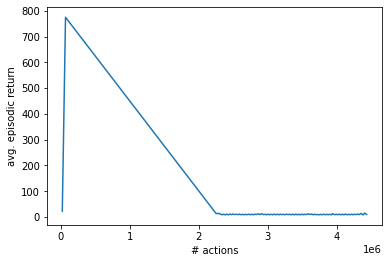

Iteration 99:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.4 | a_k(R): 11.75 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 9.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.6 | a_k(R): 9.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.05 | a_k(R): 10.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.1 | a_k(R): 8.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 16.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 11.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 16.2 | a_k(R): 11.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 14.8 | a_k(R): 11.2 | sig: Yes
state: [0.

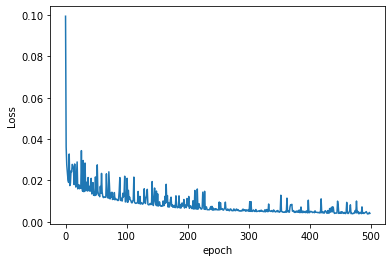

Evaluations...


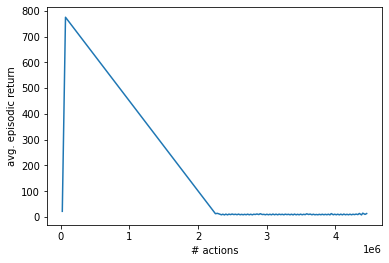

Iteration 100:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.1 | a_k(R): 13.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.35 | a_k(R): 15.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.3 | a_k(R): 14.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 14.05 | a_k(R): 14.5 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 13.9 | a_k(R): 16.85 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 13.9 | a_k(R): 16.35 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.45 | a_k(R): 12.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.3 | a_k(R): 13.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.3 | a_k(R): 12.85 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 12.75 | a_k(R): 13.0 | sig: --
state

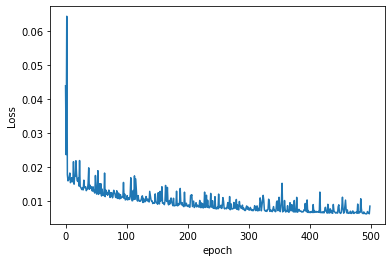

Evaluations...


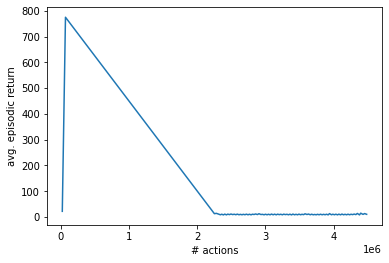

Iteration 101:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.5 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.85 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 16.25 | a_k(R): 11.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 16.4 | a_k(R): 10.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.0 | a_k(R): 10.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.8 | a_k(R): 10.45 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.75 | a_k(R): 9.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.4 | a_k(R): 9.7 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 16.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 11.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 16.2 | a_k(R): 11.7 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 15.4 | a_k(R): 11.6 | sig: Yes
state: 

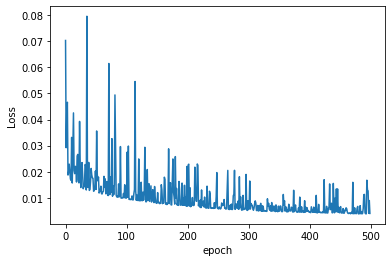

Evaluations...


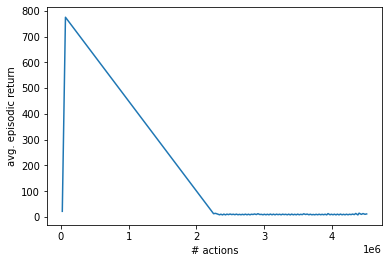

Iteration 102:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.5 | a_k(R): 12.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.7 | a_k(R): 13.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.9 | a_k(R): 13.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.9 | a_k(R): 12.95 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.9 | a_k(R): 14.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.8 | a_k(R): 14.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 10.7 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 11.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.95 | a_k(R): 11.75 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.3 | a_k(R): 12.1 | sig: Yes
stat

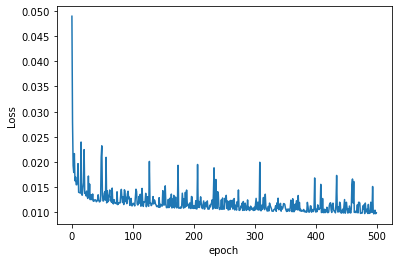

Evaluations...


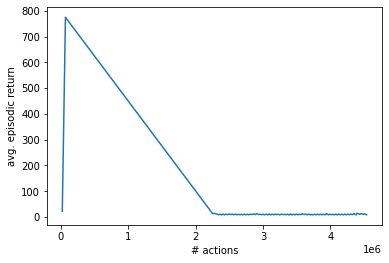

Iteration 103:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.65 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.95 | a_k(R): 9.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.45 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.55 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.1 | a_k(R): 8.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 13.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.15 | a_k(R): 9.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.35 | a_k(R): 9.25 | sig: Yes
state: [0.

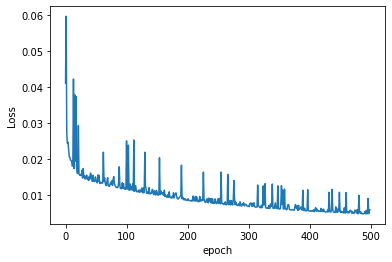

Evaluations...


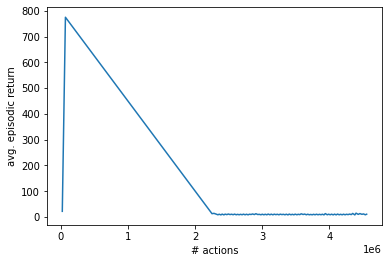

Iteration 104:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.9 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.8 | a_k(R): 10.95 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.0 | a_k(R): 12.25 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.15 | a_k(R): 12.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.05 | a_k(R): 11.95 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 13.75 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.85 | a_k(R): 13.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.85 | a_k(R): 9.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 10.25 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.8 | a_k(R): 10.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.15 | a_k(R): 11.05 | sig: Yes
state

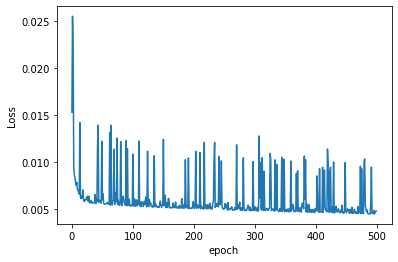

Evaluations...


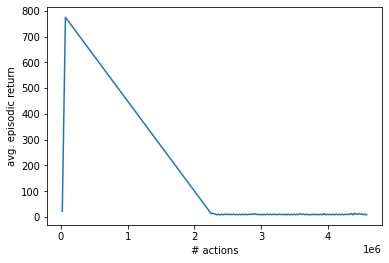

Iteration 105:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 6.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.85 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.1 | a_k(R): 9.6 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.4 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.15 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 13.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.35 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.5 | a_k(R): 9.35 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.4 | a_k(R): 9.25 | sig: Yes
state: [0.052

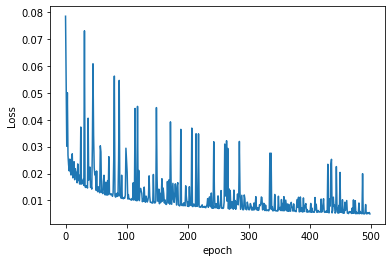

Evaluations...


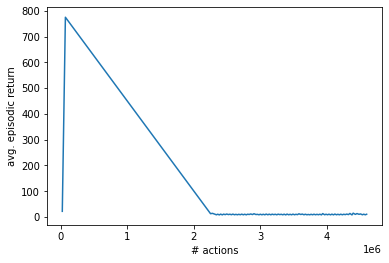

Iteration 106:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.7 | a_k(R): 10.65 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 10.4 | a_k(R): 12.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.7 | a_k(R): 12.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.8 | a_k(R): 11.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.9 | a_k(R): 13.7 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 13.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.9 | a_k(R): 10.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.4 | a_k(R): 10.05 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.1 | a_k(R): 10.8 | sig: Yes
state: [0.0

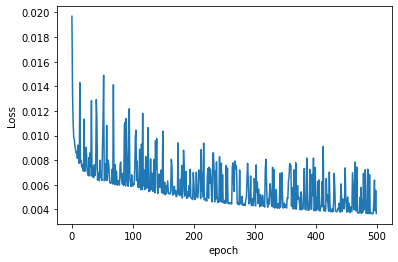

Evaluations...


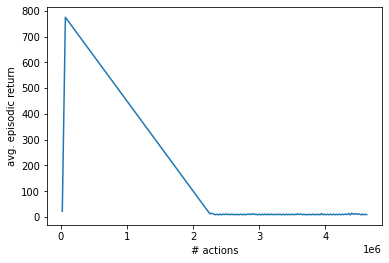

Iteration 107:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.8 | a_k(R): 5.0 | sig: --
state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 5.85 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 14.1 | a_k(R): 10.45 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.9 | a_k(R): 8.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.45 | a_k(R): 8.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.0 | a_k(R): 9.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.1 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.1 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.25 | a_k(R): 14.05 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.0 | a_k(R): 10.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 14.75 | a_k(R): 10.55 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.35 | a_k(R): 10.25 | sig: Yes
state: [0.052

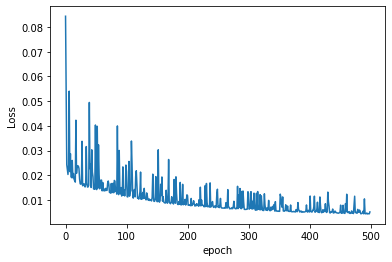

Evaluations...


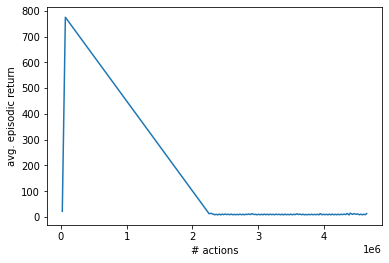

Iteration 108:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 7.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.95 | a_k(R): 7.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.2 | a_k(R): 13.2 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 13.45 | a_k(R): 14.1 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 12.75 | a_k(R): 14.5 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 13.9 | a_k(R): 14.35 | sig: --
state: [0.07469424, -0.18146342] | a_j(R): 13.75 | a_k(R): 16.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 14.7 | a_k(R): 16.45 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.4 | a_k(R): 12.9 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.15 | a_k(R): 13.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 12.85 | a_k(R): 12.55 | sig: --
state: [0.052084252, 0.24648347] | a_j(R): 13.1 | a_k(R): 13.65 | sig: --
state: [0

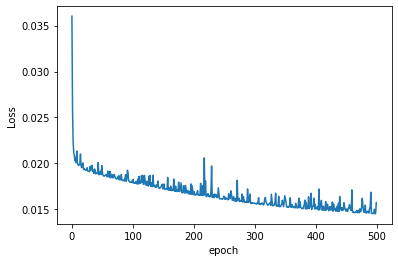

Evaluations...


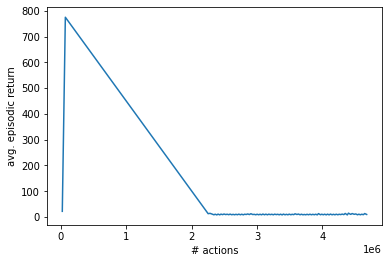

Iteration 109:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.4 | a_k(R): 5.45 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.8 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.7 | a_k(R): 6.9 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 15.5 | a_k(R): 11.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 15.7 | a_k(R): 9.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.55 | a_k(R): 9.25 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.05 | a_k(R): 9.8 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.9 | a_k(R): 9.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.15 | a_k(R): 8.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.2 | a_k(R): 15.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.25 | a_k(R): 11.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 15.65 | a_k(R): 11.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 14.55 | a_k(R): 11.05 | sig: Yes
state: 

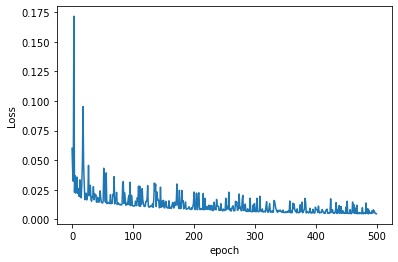

Evaluations...


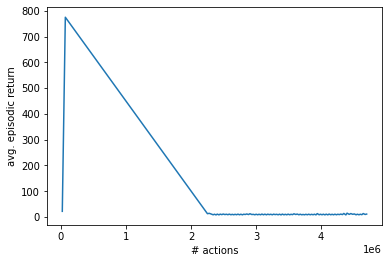

Iteration 110:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.25 | a_k(R): 11.55 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.3 | a_k(R): 12.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.4 | a_k(R): 12.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.55 | a_k(R): 12.55 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.5 | a_k(R): 14.1 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 12.25 | a_k(R): 13.95 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.2 | a_k(R): 10.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.3 | a_k(R): 11.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 11.3 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 11.1 | a_k(R): 11.6 | sig: --
state: 

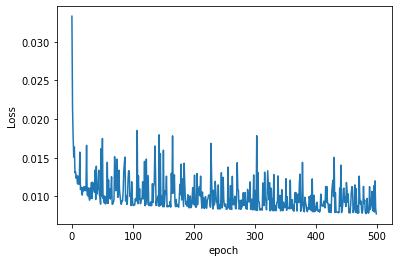

Evaluations...


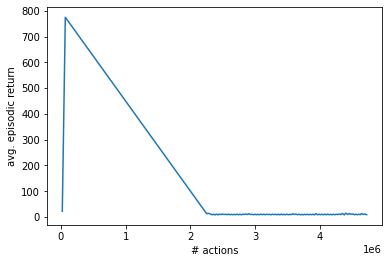

Iteration 111:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.75 | a_k(R): 10.05 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.8 | a_k(R): 8.65 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.1 | a_k(R): 8.6 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.75 | a_k(R): 9.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.65 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 9.0 | a_k(R): 8.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.9 | a_k(R): 14.2 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.05 | a_k(R): 10.2 | sig: --
state: [0.08355628, 0.70055693] | a_j(R): 13.6 | a_k(R): 10.0 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 13.05 | a_k(R): 9.95 | sig: Yes
state: [0.05208

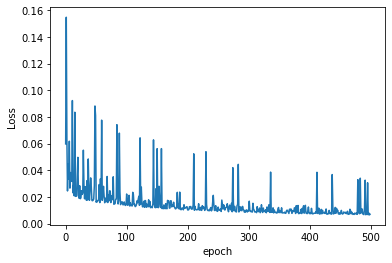

Evaluations...


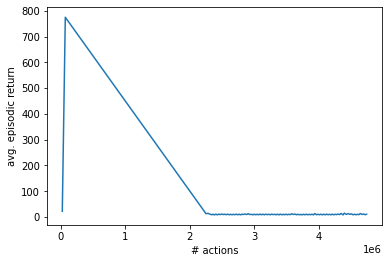

Iteration 112:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.45 | a_k(R): 11.1 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.7 | a_k(R): 11.95 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.85 | a_k(R): 11.95 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.95 | a_k(R): 11.65 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.75 | a_k(R): 13.3 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.6 | a_k(R): 13.4 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.8 | a_k(R): 9.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 10.3 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.4 | a_k(R): 10.4 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.45 | a_k(R): 10.85 | sig: Yes
state: 

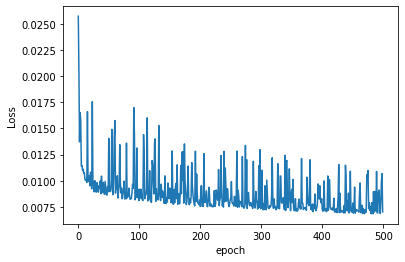

Evaluations...


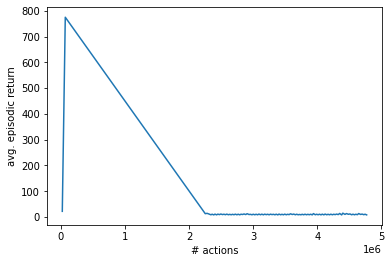

Iteration 113:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 5.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 4.6 | a_k(R): 5.6 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.55 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.95 | a_k(R): 9.3 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 13.95 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.2 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.05 | a_k(R): 8.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.05 | a_k(R): 13.65 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 8.05 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.4 | a_k(R): 9.55 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.55 | a_k(R): 9.25 | sig: Yes
state: [0.05208

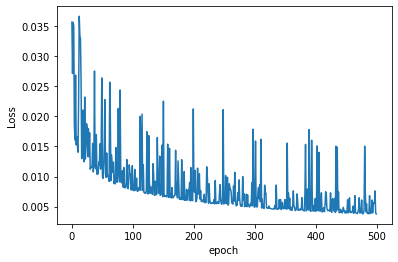

Evaluations...


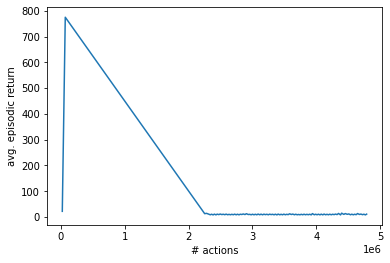

Iteration 114:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 5.9 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.0 | a_k(R): 6.95 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 6.0 | a_k(R): 6.8 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 10.95 | a_k(R): 11.2 | sig: --
state: [0.00062633306, 0.5145792] | a_j(R): 11.05 | a_k(R): 12.5 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 11.2 | a_k(R): 12.4 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.65 | a_k(R): 12.2 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.45 | a_k(R): 14.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 11.95 | a_k(R): 14.1 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.05 | a_k(R): 9.85 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.0 | a_k(R): 10.5 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 10.9 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 10.9 | a_k(R): 11.1 | sig: --
state: [0.0

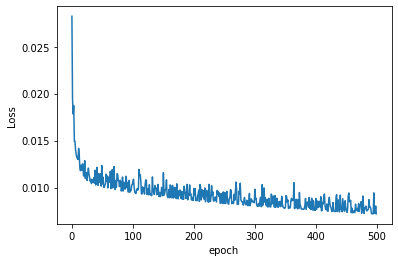

Evaluations...


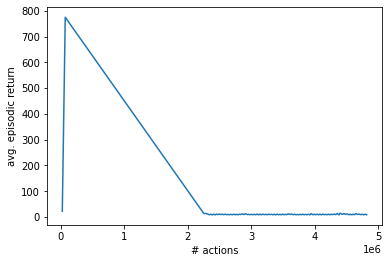

Iteration 115:


Generating roll-out preferences...

state: [0.29249486, 1.6974324] | a_j(R): 4.75 | a_k(R): 5.0 | sig: --
state: [0.29249486, 1.6974324] | a_j(R): 4.7 | a_k(R): 6.0 | sig: Yes
state: [0.29249486, 1.6974324] | a_j(R): 5.05 | a_k(R): 6.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.85 | a_k(R): 9.4 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 12.9 | a_k(R): 8.0 | sig: Yes
state: [0.00062633306, 0.5145792] | a_j(R): 9.6 | a_k(R): 8.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 8.05 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 10.0 | a_k(R): 7.0 | sig: Yes
state: [0.07469424, -0.18146342] | a_j(R): 8.15 | a_k(R): 7.0 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 9.85 | a_k(R): 13.6 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 10.0 | a_k(R): 9.55 | sig: Yes
state: [0.08355628, 0.70055693] | a_j(R): 13.2 | a_k(R): 9.45 | sig: Yes
state: [0.052084252, 0.24648347] | a_j(R): 12.65 | a_k(R): 9.25 | sig: Yes
state: [0.0520842

In [ ]:
### ### Preference-Based Policy Iteration Algorithm ###


### initializations ###

seed = 1
model_name = 'cartPole_original' # name for the LabelRanker model

env = gym.make('CustomCartPole-v0')   # environment
sample_states = generate_init_states_S(seed) # initial state list
max_iterr = 3001 # max. num. of policy iterations

act_space = partition_action_space('CustomCartPole-v0',3) # action space

act_pairs = list(itertools.combinations(act_space,2)) # generate action-pairs

policy = random_action # initial (random) policy

agg_pct_l_policies = [] # list to store the evaluation results, i.e., % of learned sufficient policies
agg_epi_returns = []    # list to store the evaluation results, i.e., avg. episodic returns
action_count_li = []    # list to store the action counts in each training iteration

label_r_flag = False  # training loop configuration ('use-label-ranker' flag) 


print(f'\nNumber of initial states: {len(sample_states)}\n')
print(f'\nNumber of actions (per states): {len(act_space)}\n')


# track iteration progress
pbar = tqdm.notebook.tqdm(total=max_iterr, desc="Iteration", position = 0)

# track preference evaluation roll-outs
track_rollouts = True

#train_data = []

iterr = 1
while iterr < max_iterr:
    
    print(f'Iteration {iterr}:')
    
    train_data = []      # place-holder to store training data
    actions_in_iterr = 0 # variable to store the num. actions excuted in each iteration

    # track state loop progress
    pbar_states = tqdm.notebook.tqdm(total=len(sample_states), desc="States", position = 1, leave=False)
    
    if track_rollouts:
        print('Generating roll-out preferences...\n')
    
    for state in sample_states:
        
        for action_pair in act_pairs:
            
            preference_out, actions_per_pair = evaluate_preference(starting_state = state
                                                                 , action_1  = np.array([[action_pair[0]]])
                                                                 , action_2  = np.array([[action_pair[1]]])
                                                                 , policy_in = policy
                                                                 , label_ranker = label_r_flag
                                                                 , n_rollouts = 20
                                                                 , p_sig = .01
                                                                 , tracking = track_rollouts )   
            
            if preference_out is not None:
                train_data.append(preference_out)
            else:
                pass
            
            # compute the number of actions executed in the iteration loop
            actions_in_iterr += actions_per_pair  
                    
        # update the state loop status
        pbar_states.update(1)
    
    print('Training dataset...')
    
    # process training data and learn the LabelRanker model
    model = train_model(train_data
                        , act_space
                        , model_name = model_name
                        , mod_layers = [50]
                        , batch_s = 4
                        , n_epochs = 500
                        , l_rate = .1
                        , show_train_plot = True
                        )
    
    # when no traiing data is found -> no model returned 
    # - therefore, break the current iteration loop and continue to the next (after upadting iterr num. and action counts)
    if model is None:
        
        print(f'No training data collected!')
        pbar.update(1)
        
        # compute the cumulative number of actions across iterations
        if iterr>1:
            action_count_li.append(actions_in_iterr+action_count_li[iterr-2])
        else:
            action_count_li.append(actions_in_iterr)
            
        iterr += 1
        continue

    del policy
    # derive a new policy using the trained model
    policy = Policy(act_space,model)
    
    # turn on the 'use-label-ranker' flag
    label_r_flag = True
    
    # compute the cumulative number of actions across iterations
    if iterr>1:
        action_count_li.append(actions_in_iterr+action_count_li[iterr-2])
    else:
        action_count_li.append(actions_in_iterr)
        
    # compute 'percent. of sufficient policies' & the 'avg. episodic returns' attained by the latest policy
    pct_succ_policies, avg_epi_return = run_evaluations(policy
                                                        , sample_states
                                                        , simulations_per_state = 10
                                                        , step_thresh=150) # steps needed for a sufficient policy
    
    agg_pct_l_policies.append(pct_succ_policies) # pct. of sufficient policies in evaluations
    agg_epi_returns.append(avg_epi_return) # avg. episodic return of evaluations
    
    # plot the 'num. actions' vs. 'pct. of sufficient policies' or 'avg. episodic returns'
    if iterr%1 == 0:
        print(f'Evaluations...')
        # clear the last plot data
        plt.clf()
        plt.cla()
        plt.close()

        # plotting rewards over iterations
        plt.plot(action_count_li, agg_epi_returns)
        #plt.ylabel('% learned sufficient policies')
        plt.ylabel('avg. episodic return')
        plt.xlabel('# actions')
        plt.savefig(f'./train_imgs/{model_name}.png') # save the evaluation image
        plt.show()  
    
    # update the algorithm iteration status
    pbar.update(1)
    iterr += 1
        
pbar.close()

###################################################